downloading dataset

In [ ]:
 # Step 0: Setup Kaggle API (for Kaggle datasets)
# Upload your kaggle.json API token file from your local and run this cell
from google.colab import files
files.upload()  # Upload kaggle.json

# Move kaggle.json to the right place and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install necessary packages
!pip install roboflow --quiet

# Step 1: Download PlantDoc dataset (GitHub or Roboflow)
# Option 1: Download via Roboflow (requires API key, if you have)
# from roboflow import Roboflow
# rf = Roboflow(api_key="YOUR_API_KEY")
# project = rf.workspace().project("plantdoc")
# dataset = project.version(1).download("yolov5")

# Option 2: Download PlantDoc from GitHub (zip)
!wget -q https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip
!unzip -q master.zip
!mv PlantDoc-Dataset-master PlantDoc

# Step 2: Download PlantVillage dataset (via Kaggle)
!kaggle datasets download emmarex/plantdisease -p ./PlantVillage --unzip

# Step 3: Download Kaggle Corn Leaf Disease Dataset
!kaggle datasets download ashishjangra27/plantdiseases -p ./CornApple --unzip

# Step 4: Show directory structure and class counts to check balance
import os
from collections import Counter

def count_images_by_class(path):
    class_counts = {}
    for root, dirs, files in os.walk(path):
        for d in dirs:
            class_path = os.path.join(root, d)
            num_files = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
            if num_files > 0:
                class_counts[d] = class_counts.get(d, 0) + num_files
    return class_counts

print("PlantDoc classes and counts:")
print(count_images_by_class("./PlantDoc"))

print("\nPlantVillage classes and counts:")
print(count_images_by_class("./PlantVillage"))

print("\nCorn/Apple Leaf Dataset classes and counts:")
print(count_images_by_class("./CornApple"))

# Step 5: Prepare folders for severity annotation (manual/semi-auto)
severity_levels = ['mild', 'moderate', 'severe', 'healthy']

base_annotation_dir = './Severity_Annotations'
os.makedirs(base_annotation_dir, exist_ok=True)


for lvl in severity_levels:
    os.makedirs(os.path.join(base_annotation_dir, lvl), exist_ok=True)

print(f"Created folders for severity annotation at {base_annotation_dir}")

# You can manually move images into these folders for severity labels or build your own annotation script later.



Saving kaggle.json to kaggle.json
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 124.0 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 654M/658M [00:03<00:00, 149MB/s]
100% 658M/658M [00:03<00:00, 197MB/s]
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/ashishjangra27/plantdiseases
PlantDoc classes and counts:
{'Cherry leaf': 57, 'Tomato leaf mosaic virus': 54, 'Tomato leaf late blight': 111, 'Bell_pepper leaf': 61, 'Tomato leaf': 63, 'Blueberry leaf': 117, 'Tomato leaf bacterial spot': 110, 'Soyabean leaf': 65, 'Raspberry leaf': 119, 'Tomato Septoria leaf spot': 151, 'Corn ru

individual plantvillage training

In [ ]:
!pip install albumentations --quiet
import os, random, shutil, gc, cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === CONFIG ===
dataset_name = "PlantVillage"
input_dir = "./PlantVillage/plantvillage/PlantVillage"  # ✅ fixed
output_dir = f"./Split_{dataset_name}"

IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Step 1: 3-Way Stratified Split ===
def stratified_split(dataset_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    os.makedirs(output_path, exist_ok=True)
    for phase in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, phase), exist_ok=True)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        n = len(images)
        train_split = int(n * train_ratio)
        val_split = train_split + int(n * val_ratio)
        test_split = n - train_split - val_split # Calculate test split size
        splits = {
            'train': images[:train_split],
            'val': images[train_split:val_split],
            'test': images[val_split:]
        }
        for phase, imgs in splits.items():
            out_dir = os.path.join(output_dir, phase, cls)
            os.makedirs(out_dir, exist_ok=True)
            for img in imgs:
                shutil.copy2(os.path.join(cls_path, img), os.path.join(out_dir, img))

stratified_split(input_dir, output_dir)

# === Step 2: Transforms
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5), A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std), ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std), ToTensorV2()
])

# === Step 3: Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths, self.labels = [], []
        self.transform = transform
        self.class_to_idx = class_to_idx
        # Ensure root_dir exists before listing
        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} not found. Skipping dataset.")
            return

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform: image = self.transform(image=image)['image']
        return image, self.labels[idx]

# === Step 4: Class Mapping + DataLoader Setup
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Get class counts for directories with images in the training set
class_counts = {}
for d in os.listdir(train_dir):
    dir_path = os.path.join(train_dir, d)
    if os.path.isdir(dir_path):
        num_images = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if num_images > 0:
            class_counts[d] = num_images

# Create the list of classes from the filtered class_counts
classes = sorted(class_counts.keys())

if not classes:
    raise ValueError("No classes found in the training set after splitting.")

class_to_idx = {cls: i for i, cls in enumerate(classes)}
total = sum(class_counts.values())
weights = {cls: total/class_counts[cls] for cls in classes}
max_w = max(weights.values())
class_weights_tensor = torch.FloatTensor([weights[cls]/max_w for cls in classes]).to(DEVICE)


train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, val_transforms), batch_size=BATCH_SIZE)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, val_transforms), batch_size=BATCH_SIZE)

# === Step 5: Model Setup
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()

# === Step 6: Training Functions
def train_one_epoch(model):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

# === Step 7: Train the Model
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model)
    val_loss, val_acc = validate(model)
    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    torch.cuda.empty_cache(); gc.collect()

# === Step 8: Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
idx_to_class = {v: k for k, v in class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(classes))]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title(f"{dataset_name} - Test Set Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 43.6MB/s]
/tmp/ipython-input-22-778888090.py:137: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-22-778888090.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 

test accuracy

In [ ]:
import numpy as np

# Check if test results are available
if all_preds and all_labels:
    test_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
else:
    print("⚠️ Test predictions not found. You need to re-run the evaluation block.")


individual plantdoc training

In [ ]:
!pip install albumentations --quiet
import os, random, shutil, gc, cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === CONFIG ===
dataset_name = "PlantDoc"
input_dir = "/content/PlantDoc/train"  # ✅ use only the train folder
output_dir = f"./Split_{dataset_name}"

IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Step 1: 3-Way Stratified Split ===
def stratified_split(dataset_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    os.makedirs(output_path, exist_ok=True)
    for phase in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, phase), exist_ok=True)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        n = len(images)
        train_split = int(n * train_ratio)
        val_split = train_split + int(n * val_ratio)
        test_split = n - train_split - val_split # Calculate test split size
        splits = {
            'train': images[:train_split],
            'val': images[train_split:val_split],
            'test': images[val_split:]
        }
        for phase, imgs in splits.items():
            out_dir = os.path.join(output_dir, phase, cls)
            os.makedirs(out_dir, exist_ok=True)
            for img in imgs:
                shutil.copy2(os.path.join(cls_path, img), os.path.join(out_dir, img))

stratified_split(input_dir, output_dir)

# === Step 2: Transforms
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5), A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std), ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std), ToTensorV2()
])

# === Step 3: Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths, self.labels = [], []
        self.transform = transform
        self.class_to_idx = class_to_idx
        # Ensure root_dir exists before listing
        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} not found. Skipping dataset.")
            return

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform: image = self.transform(image=image)['image']
        return image, self.labels[idx]

# === Step 4: Class Mapping + DataLoader Setup
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Get class counts for directories with images in the training set
class_counts = {}
for d in os.listdir(train_dir):
    dir_path = os.path.join(train_dir, d)
    if os.path.isdir(dir_path):
        num_images = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if num_images > 0:
            class_counts[d] = num_images

# Create the list of classes from the filtered class_counts
classes = sorted(class_counts.keys())

if not classes:
    raise ValueError("No classes found in the training set after splitting.")

class_to_idx = {cls: i for i, cls in enumerate(classes)}
total = sum(class_counts.values())
weights = {cls: total/class_counts[cls] for cls in classes}
max_w = max(weights.values())
class_weights_tensor = torch.FloatTensor([weights[cls]/max_w for cls in classes]).to(DEVICE)


train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, val_transforms), batch_size=BATCH_SIZE)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, val_transforms), batch_size=BATCH_SIZE)

# === Step 5: Model Setup
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()

# === Step 6: Training Functions
def train_one_epoch(model):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

# === Step 7: Train the Model
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model)
    val_loss, val_acc = validate(model)
    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    torch.cuda.empty_cache(); gc.collect()

# === Step 8: Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
idx_to_class = {v: k for k, v in class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(classes))]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title(f"{dataset_name} - Test Set Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

test accuracy

In [ ]:
import numpy as np

# Ensure all_preds and all_labels exist from evaluation
test_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")


merging

In [ ]:
import os
import shutil
from pathlib import Path

# Source directories - adjust if needed
plantdoc_dir = './PlantDoc'
plantvillage_dir = './PlantVillage'

# Target merged directory
merged_dir = './MergedPlantDataset'
os.makedirs(merged_dir, exist_ok=True)

# Basic class name mapping: PlantVillage class names -> Unified class names
# Add mappings as per your dataset and preference
class_mapping = {
    # PlantVillage -> Unified
    'Tomato_Leaf_Mold': 'Tomato Leaf Mold',
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 'Tomato Yellow Leaf Curl Virus',
    'Pepper__bell___healthy': 'Bell Pepper Healthy',
    'Tomato_Bacterial_spot': 'Tomato Bacterial Spot',
    'Tomato_Early_blight': 'Tomato Early Blight',
    'Tomato__Target_Spot': 'Tomato Target Spot',
    'Tomato_Septoria_leaf_spot': 'Tomato Septoria Leaf Spot',
    'Pepper__bell___Bacterial_spot': 'Bell Pepper Bacterial Spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'Tomato Two Spotted Spider Mite',
    'Potato___healthy': 'Potato Healthy',
    'Tomato_Late_blight': 'Tomato Late Blight',
    'Tomato__Tomato_mosaic_virus': 'Tomato Mosaic Virus',
    'Potato___Late_blight': 'Potato Late Blight',
    'Potato___Early_blight': 'Potato Early Blight',
    'Tomato_healthy': 'Tomato Healthy',
    # Add PlantDoc classes as unified names (assuming same names)
    'Corn rust leaf': 'Corn Rust Leaf',
    'Tomato mold leaf': 'Tomato Mold Leaf',
    'Tomato leaf mosaic virus': 'Tomato Mosaic Virus',
    'Tomato leaf yellow virus': 'Tomato Yellow Leaf Curl Virus',
    'Corn leaf blight': 'Corn Leaf Blight',
    'Apple rust leaf': 'Apple Rust Leaf',
    'Potato leaf early blight': 'Potato Early Blight',
    'Blueberry leaf': 'Blueberry Leaf',
    'Tomato Early blight leaf': 'Tomato Early Blight',
    'Soyabean leaf': 'Soyabean Leaf',
    'Tomato Septoria leaf spot': 'Tomato Septoria Leaf Spot',
    'Raspberry leaf': 'Raspberry Leaf',
    'Bell_pepper leaf': 'Bell Pepper Leaf',
    'Apple leaf': 'Apple Leaf',
    'Tomato leaf late blight': 'Tomato Late Blight',
    'grape leaf black rot': 'Grape Leaf Black Rot',
    'Corn Gray leaf spot': 'Corn Gray Leaf Spot',
    'Strawberry leaf': 'Strawberry Leaf',
    'Potato leaf late blight': 'Potato Late Blight',
    'Peach leaf': 'Peach Leaf',
    'Apple Scab Leaf': 'Apple Scab Leaf',
    'Cherry leaf': 'Cherry Leaf',
    'Bell_pepper leaf spot': 'Bell Pepper Leaf Spot',
    'Squash Powdery mildew leaf': 'Squash Powdery Mildew Leaf',
    'Tomato leaf bacterial spot': 'Tomato Bacterial Spot',
    'grape leaf': 'Grape Leaf',
    'Tomato leaf': 'Tomato Leaf',
    'Tomato two spotted spider mites leaf': 'Tomato Two Spotted Spider Mite'
}

def unify_class_name(orig_class_name):
    if orig_class_name in class_mapping:
        return class_mapping[orig_class_name]
    else:
        # If not mapped, return original cleaned name
        return orig_class_name.replace('_',' ').title()

def copy_images(src_root, is_plantdoc=False):
    """
    Copies images from source dataset folder to merged_dir with unified class folders.
    is_plantdoc: PlantDoc has slightly different structure, this adjusts accordingly.
    """
    print(f"Processing dataset at {src_root} ...")

    # List class folders inside src_root
    for root, dirs, files in os.walk(src_root):
        for d in dirs:
            class_dir = os.path.join(root, d)
            unified_class = unify_class_name(d)
            target_class_dir = os.path.join(merged_dir, unified_class)
            os.makedirs(target_class_dir, exist_ok=True)

            # Copy all image files from class_dir to target_class_dir
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_file = os.path.join(class_dir, file)
                    # To avoid overwriting same filename, prefix with dataset name
                    prefix = 'plantdoc' if is_plantdoc else 'plantvillage'
                    dst_file = os.path.join(target_class_dir, f"{prefix}_{file}")
                    shutil.copy2(src_file, dst_file)
            print(f"Copied class '{d}' as '{unified_class}'")

print("Start copying PlantDoc dataset...")
copy_images(plantdoc_dir, is_plantdoc=True)

print("\nStart copying PlantVillage dataset...")
copy_images(plantvillage_dir, is_plantdoc=False)

print("\nDone merging datasets!")
print(f"Check merged dataset folder: {merged_dir}")


Start copying PlantDoc dataset...
Processing dataset at ./PlantDoc ...
Copied class 'test' as 'Test'
Copied class 'train' as 'Train'
Copied class 'Cherry leaf' as 'Cherry Leaf'
Copied class 'Tomato leaf mosaic virus' as 'Tomato Mosaic Virus'
Copied class 'Tomato leaf late blight' as 'Tomato Late Blight'
Copied class 'Bell_pepper leaf' as 'Bell Pepper Leaf'
Copied class 'Tomato leaf' as 'Tomato Leaf'
Copied class 'Blueberry leaf' as 'Blueberry Leaf'
Copied class 'Tomato leaf bacterial spot' as 'Tomato Bacterial Spot'
Copied class 'Soyabean leaf' as 'Soyabean Leaf'
Copied class 'Raspberry leaf' as 'Raspberry Leaf'
Copied class 'Tomato Septoria leaf spot' as 'Tomato Septoria Leaf Spot'
Copied class 'Corn rust leaf' as 'Corn Rust Leaf'
Copied class 'Potato leaf late blight' as 'Potato Late Blight'
Copied class 'Tomato mold leaf' as 'Tomato Mold Leaf'
Copied class 'Bell_pepper leaf spot' as 'Bell Pepper Leaf Spot'
Copied class 'Squash Powdery mildew leaf' as 'Squash Powdery Mildew Leaf'
Cop

removing invalid folders

In [ ]:
import os
import shutil

# Path to your merged dataset folder
merged_dataset_path = './MergedPlantDataset'

# List to hold classes with images
valid_classes = []

# Scan each class folder
for class_name in os.listdir(merged_dataset_path):
    class_folder = os.path.join(merged_dataset_path, class_name)
    if os.path.isdir(class_folder):
        # Count number of images/files in the folder
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        if num_images == 0:
            print(f"Removing empty class folder: {class_name}")
            shutil.rmtree(class_folder)  # Remove empty folder
        else:
            valid_classes.append(class_name)

print(f"\nValid classes with images ({len(valid_classes)}):")
for cls in valid_classes:
    print(f"- {cls}")

# Save valid classes list if needed for label mapping later
with open('valid_classes.txt', 'w') as f:
    for cls in valid_classes:
        f.write(cls + '\n')
print("\nValid classes list saved to 'valid_classes.txt'")


Removing empty class folder: Plantvillage
Removing empty class folder: Test
Removing empty class folder: Train

Valid classes with images (34):
- Tomato Yellow Leaf Curl Virus
- Squash Powdery Mildew Leaf
- Tomato Leaf
- Tomato Early Blight
- Bell Pepper Bacterial Spot
- Potato Healthy
- Corn Rust Leaf
- Blueberry Leaf
- Tomato Target Spot
- Tomato Bacterial Spot
- Apple Rust Leaf
- Bell Pepper Leaf
- Raspberry Leaf
- Potato Early Blight
- Tomato Septoria Leaf Spot
- Strawberry Leaf
- Potato Late Blight
- Tomato Healthy
- Tomato Mosaic Virus
- Soyabean Leaf
- Bell Pepper Leaf Spot
- Grape Leaf
- Apple Leaf
- Peach Leaf
- Tomato Two Spotted Spider Mite
- Corn Gray Leaf Spot
- Cherry Leaf
- Corn Leaf Blight
- Grape Leaf Black Rot
- Apple Scab Leaf
- Tomato Mold Leaf
- Tomato Leaf Mold
- Bell Pepper Healthy
- Tomato Late Blight

Valid classes list saved to 'valid_classes.txt'


dataset visualization merged dataset

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the merged dataset
merged_dir = './MergedPlantDataset'

def visualize_dataset(merged_dir, samples_per_class=5):
    class_dirs = [d for d in os.listdir(merged_dir) if os.path.isdir(os.path.join(merged_dir, d))]

    for class_name in class_dirs:
        class_path = os.path.join(merged_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not images:
            continue  # Skip empty folders

        selected_images = random.sample(images, min(len(images), samples_per_class))

        plt.figure(figsize=(15, 3))
        plt.suptitle(f"{class_name} - {len(images)} images", fontsize=14)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                plt.subplot(1, samples_per_class, i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(img_name[:15] + "..." if len(img_name) > 15 else img_name)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        plt.tight_layout()
        plt.show()

# Visualize the merged dataset
visualize_dataset(merged_dir, samples_per_class=5)


splitting

In [ ]:
import os
import shutil
import random

dataset_dir = './MergedPlantDataset'
output_dir = './PlantDatasetSplit3Way'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

random.seed(42)

classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)

    n = len(images)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("3-way dataset split complete!")
print(f"Train folder: {train_dir}")
print(f"Validation folder: {val_dir}")
print(f"Test folder: {test_dir}")


3-way dataset split complete!
Train folder: ./PlantDatasetSplit3Way/train
Validation folder: ./PlantDatasetSplit3Way/val
Test folder: ./PlantDatasetSplit3Way/test


In [ ]:
from collections import Counter
import os

def count_images(folder):
    count = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            count[cls] = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    return count

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("Train:", train_counts)
print("Val:", val_counts)
print("Test:", test_counts)


Train: {'Tomato Yellow Leaf Curl Virus': 48, 'Squash Powdery Mildew Leaf': 91, 'Tomato Leaf': 44, 'Tomato Early Blight': 54, 'Bell Pepper Bacterial Spot': 0, 'Potato Healthy': 0, 'Corn Rust Leaf': 81, 'Blueberry Leaf': 81, 'Tomato Target Spot': 0, 'Tomato Bacterial Spot': 83, 'Apple Rust Leaf': 62, 'Bell Pepper Leaf': 42, 'Raspberry Leaf': 83, 'Potato Early Blight': 80, 'Tomato Septoria Leaf Spot': 96, 'Strawberry Leaf': 67, 'Potato Late Blight': 78, 'Tomato Healthy': 1, 'Tomato Mosaic Virus': 38, 'Soyabean Leaf': 45, 'Bell Pepper Leaf Spot': 49, 'Grape Leaf': 48, 'Apple Leaf': 63, 'Peach Leaf': 78, 'Tomato Two Spotted Spider Mite': 2, 'Corn Gray Leaf Spot': 47, 'Cherry Leaf': 39, 'Corn Leaf Blight': 134, 'Grape Leaf Black Rot': 44, 'Apple Scab Leaf': 65, 'Tomato Mold Leaf': 63, 'Tomato Leaf Mold': 0, 'Bell Pepper Healthy': 2, 'Tomato Late Blight': 180}
Val: {'Tomato Yellow Leaf Curl Virus': 13, 'Squash Powdery Mildew Leaf': 19, 'Tomato Leaf': 9, 'Tomato Early Blight': 15, 'Bell Pepper

In [ ]:
import os
from collections import Counter
import numpy as np
import torch

train_dir = './PlantDatasetSplit3Way/train'

def get_class_counts(directory):
    class_counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[cls] = count
    return class_counts

class_counts = get_class_counts(train_dir)
print("Training samples per class:")
print(class_counts)

# Compute class weights: inverse frequency
total_samples = sum(class_counts.values())

# Add a check to ensure count is not zero before calculating weight
# This prevents ZeroDivisionError if a class has no samples in the training set
class_weights = {cls: total_samples/count for cls, count in class_counts.items() if count > 0}

# Normalize weights (optional)
# Only calculate max_weight if class_weights is not empty
if class_weights:
    max_weight = max(class_weights.values())
    class_weights = {cls: w/max_weight for cls, w in class_weights.items()}
else:
    # Handle the case where class_weights is empty (e.g., no images in training set)
    # This might indicate a larger issue with the data loading/splitting
    print("Warning: No samples found in the training set to calculate class weights.")
    max_weight = 1 # Prevent division by zero if class_weights is empty
    class_weights = {}


print("\nNormalized class weights:")
print(class_weights)

# Create a list of weights matching class index order
# First, get sorted class list based on classes that actually have samples
sorted_classes = sorted(class_weights.keys()) # Use keys from the filtered class_weights
class_to_idx = {cls: idx for idx, cls in enumerate(sorted_classes)}
weights_list = [class_weights[cls] for cls in sorted_classes]

# Ensure weights_list is not empty before creating the tensor
if weights_list:
    class_weights_tensor = torch.FloatTensor(weights_list)
else:
    # Handle the case where weights_list is empty
    print("Warning: weights_list is empty. Class weights tensor cannot be created.")
    class_weights_tensor = torch.FloatTensor([]) # Create an empty tensor or handle as needed


print("\nClass to index mapping:")
print(class_to_idx)

Training samples per class:
{'Tomato Yellow Leaf Curl Virus': 2298, 'Squash Powdery Mildew Leaf': 91, 'Tomato Leaf': 44, 'Tomato Early Blight': 761, 'Bell Pepper Bacterial Spot': 697, 'Potato Healthy': 106, 'Corn Rust Leaf': 81, 'Blueberry Leaf': 81, 'Tomato Target Spot': 982, 'Tomato Bacterial Spot': 1565, 'Apple Rust Leaf': 62, 'Bell Pepper Leaf': 42, 'Raspberry Leaf': 83, 'Potato Early Blight': 781, 'Tomato Septoria Leaf Spot': 1344, 'Strawberry Leaf': 67, 'Potato Late Blight': 773, 'Tomato Healthy': 1113, 'Tomato Mosaic Virus': 298, 'Soyabean Leaf': 45, 'Bell Pepper Leaf Spot': 49, 'Grape Leaf': 48, 'Apple Leaf': 63, 'Peach Leaf': 78, 'Tomato Two Spotted Spider Mite': 1174, 'Corn Gray Leaf Spot': 47, 'Cherry Leaf': 39, 'Corn Leaf Blight': 134, 'Grape Leaf Black Rot': 44, 'Apple Scab Leaf': 65, 'Tomato Mold Leaf': 63, 'Tomato Leaf Mold': 666, 'Bell Pepper Healthy': 1034, 'Tomato Late Blight': 1414}

Normalized class weights:
{'Tomato Yellow Leaf Curl Virus': 0.016971279373368144, 'S

teacher model i am confused kuntu code loisu either eitu nhole :

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from PIL import Image
import gc

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Albumentations Augmentation Pipeline ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    # Optional: A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Class ===
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx: # Only process valid classes
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Dataset Paths ===
train_dir = './PlantDatasetSplit3Way/train'
val_dir = './PlantDatasetSplit3Way/val'
test_dir = './PlantDatasetSplit3Way/test'

# === Class Mapping & Weights ===
def get_class_counts(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
             count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
             if count > 0: # Only include classes with images
                 counts[cls] = count
    return counts

class_counts = get_class_counts(train_dir)
total = sum(class_counts.values())

# Update class_to_idx based on classes with samples
classes_with_samples = sorted(class_counts.keys())
class_to_idx = {cls: i for i, cls in enumerate(classes_with_samples)}

weights = {cls: total / count for cls, count in class_counts.items()}
max_w = max(weights.values()) if weights else 1 # Handle case where weights is empty
weights = {cls: w / max_w for cls, w in weights.items()}

# Create weights tensor for the classes that have samples
class_weights_list = [weights[cls] for cls in classes_with_samples]
class_weights_tensor = torch.FloatTensor(class_weights_list).to(DEVICE)

# === Datasets and Loaders ===
train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes_with_samples[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# === Model Setup ===
# Adjust the number of output features based on the actual number of classes with samples
num_classes = len(classes_with_samples)
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(DEVICE)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()

# === Training Loop with Mixed Precision ===
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# === Run Training ===
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

nhole eitu below : model tu chatgptt di check kriloba kuntu code if architecture ba kba krne lga hoi

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from PIL import Image
import gc

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Albumentations Augmentation Pipeline ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    # Optional: A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Class ===
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx: # Only process valid classes
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Dataset Paths ===
train_dir = './PlantDatasetSplit3Way/train'
val_dir = './PlantDatasetSplit3Way/val'
test_dir = './PlantDatasetSplit3Way/test'

# === Class Mapping & Weights ===
def get_class_counts(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
             count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
             if count > 0: # Only include classes with images
                 counts[cls] = count
    return counts

class_counts = get_class_counts(train_dir)
total = sum(class_counts.values())

# Update class_to_idx based on classes with samples
classes_with_samples = sorted(class_counts.keys())
class_to_idx = {cls: i for i, cls in enumerate(classes_with_samples)}

weights = {cls: total / count for cls, count in class_counts.items()}
max_w = max(weights.values()) if weights else 1 # Handle case where weights is empty
weights = {cls: w / max_w for cls, w in weights.items()}

# Create weights tensor for the classes that have samples
class_weights_list = [weights[cls] for cls in classes_with_samples]
class_weights_tensor = torch.FloatTensor(class_weights_list).to(DEVICE)

# === Datasets and Loaders ===
train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes_with_samples[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# === Model Setup ===
# Adjust the number of output features based on the actual number of classes with samples
num_classes = len(classes_with_samples)
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(DEVICE)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()

# === Training Loop with Mixed Precision ===
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# === Run Training ===
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

prediction with confidence(eitu uprt kam kribo ase plantvillage t kio kom k ahe confidence ru plantdoc t kio bsik ahe)

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A
import numpy as np
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# === CONFIG ===
IMG_SIZE = 300
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Albumentations Transform ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Load Model Checkpoint ===
model_path = "/content/efficientnet_b4_plant_disease.pth"
checkpoint = torch.load(model_path, map_location=DEVICE)

# === Load and Modify Model ===
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

if 'class_to_idx' in checkpoint:
    class_to_idx = checkpoint['class_to_idx']
    num_classes = len(class_to_idx)
    print(f"Loaded class_to_idx with {num_classes} classes.")
else:
    raise KeyError("'class_to_idx' not found in checkpoint. Cannot set classifier size.")

# Modify classifier to match class count
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval().to(DEVICE)

# === Prediction Function ===
def predict_image(image_path, model, transform, class_to_idx):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()  # For visualization

    # Transform for model input
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    # Map prediction to label
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    predicted_label = idx_to_class[pred_class]
    confidence = probs[0][pred_class].item()

    return original_image, predicted_label, confidence

# === Predict and Visualize ===
img_path = "/content/MergedPlantDataset/Bell Pepper Bacterial Spot/plantvillage_0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"
image, pred, conf = predict_image(img_path, model, val_transforms, class_to_idx)

# === Show Original Image with Prediction ===
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediction: {pred} ({conf*100:.2f}%)", fontsize=14)
plt.show()


teacher model tu load kri test accuracy

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reload your class mapping ===
# Make sure class_to_idx is exactly as in training
# Example placeholder: replace with your actual mapping
class_to_idx = {'Apple Leaf': 0, 'Apple Rust Leaf': 1, 'Apple Scab Leaf': 2, 'Bell Pepper Bacterial Spot': 3, 'Bell Pepper Healthy': 4, 'Bell Pepper Leaf': 5, 'Bell Pepper Leaf Spot': 6, 'Blueberry Leaf': 7, 'Cherry Leaf': 8, 'Corn Gray Leaf Spot': 9, 'Corn Leaf Blight': 10, 'Corn Rust Leaf': 11, 'Grape Leaf': 12, 'Grape Leaf Black Rot': 13, 'Peach Leaf': 14, 'Potato Early Blight': 15, 'Potato Healthy': 16, 'Potato Late Blight': 17, 'Raspberry Leaf': 18, 'Soyabean Leaf': 19, 'Squash Powdery Mildew Leaf': 20, 'Strawberry Leaf': 21, 'Tomato Bacterial Spot': 22, 'Tomato Early Blight': 23, 'Tomato Healthy': 24, 'Tomato Late Blight': 25, 'Tomato Leaf': 26, 'Tomato Leaf Mold': 27, 'Tomato Mold Leaf': 28, 'Tomato Mosaic Virus': 29, 'Tomato Septoria Leaf Spot': 30, 'Tomato Target Spot': 31, 'Tomato Two Spotted Spider Mite': 32, 'Tomato Yellow Leaf Curl Virus': 33}  # Fill this
num_classes = len(class_to_idx)

# === Rebuild the model architecture ===
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(DEVICE)

# === Load the trained weights ===
# Load the entire checkpoint dictionary first
checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
# Load only the model_state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
print("✅ Model loaded successfully.")

In [ ]:
import os, cv2
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Dataset class (same as before) ===
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# === Transforms ===
IMG_SIZE = 300
val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# === Load test set ===
test_dir = "./PlantDatasetSplit3Way/test"
test_dataset = PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
from sklearn.metrics import accuracy_score

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


test set confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = list(class_to_idx.keys())

# Display confusion matrix
plt.figure(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix - Test Set (Merged Model)")
plt.tight_layout()
plt.show()


normalized confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Normalized confusion matrix
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')
labels = list(class_to_idx.keys())

plt.figure(figsize=(18, 18))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=90, values_format=".2f")
plt.title("Normalized Confusion Matrix - Test Set (Merged Model)")
plt.tight_layout()
plt.show()


top 3 mis classified

In [ ]:
import numpy as np

# Non-normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds)
errors = cm.sum(axis=1) - np.diag(cm)  # total errors per class

# Get top 3 misclassified classes
top3_indices = np.argsort(errors)[-3:][::-1]  # descending
print("Top-3 Most Misclassified Classes:")
for i in top3_indices:
    print(f"{labels[i]} ➤ Misclassified {errors[i]} times")


classificatopn report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=labels, digits=4)
print("📊 Classification Report:\n")
print(report)


GRAD-CAM

In [ ]:
!pip install grad-cam --quiet


In [ ]:
import torch, cv2, os, random, numpy as np
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from albumentations.pytorch import ToTensorV2
import albumentations as A


In [ ]:
IMG_SIZE = 300
val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
class_to_idx = {'Apple Leaf': 0, 'Apple Rust Leaf': 1, 'Apple Scab Leaf': 2, 'Bell Pepper Bacterial Spot': 3, 'Bell Pepper Healthy': 4, 'Bell Pepper Leaf': 5, 'Bell Pepper Leaf Spot': 6, 'Blueberry Leaf': 7, 'Cherry Leaf': 8, 'Corn Gray Leaf Spot': 9, 'Corn Leaf Blight': 10, 'Corn Rust Leaf': 11, 'Grape Leaf': 12, 'Grape Leaf Black Rot': 13, 'Peach Leaf': 14, 'Potato Early Blight': 15, 'Potato Healthy': 16, 'Potato Late Blight': 17, 'Raspberry Leaf': 18, 'Soyabean Leaf': 19, 'Squash Powdery Mildew Leaf': 20, 'Strawberry Leaf': 21, 'Tomato Bacterial Spot': 22, 'Tomato Early Blight': 23, 'Tomato Healthy': 24, 'Tomato Late Blight': 25, 'Tomato Leaf': 26, 'Tomato Leaf Mold': 27, 'Tomato Mold Leaf': 28, 'Tomato Mosaic Virus': 29, 'Tomato Septoria Leaf Spot': 30, 'Tomato Target Spot': 31, 'Tomato Two Spotted Spider Mite': 32, 'Tomato Yellow Leaf Curl Virus': 33}



In [ ]:
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(class_to_idx))
model.load_state_dict(torch.load("/content/efficientnet_b4_plant_disease.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu')['model_state_dict'])
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()


In [ ]:
!pip install grad-cam --quiet

# STEP 2: Imports
import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from albumentations.pytorch import ToTensorV2
import albumentations as A

# STEP 3: Configuration
IMG_SIZE = 300
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = {'Apple Leaf': 0, 'Apple Rust Leaf': 1, 'Apple Scab Leaf': 2,
                'Bell Pepper Bacterial Spot': 3, 'Bell Pepper Healthy': 4, 'Bell Pepper Leaf': 5,
                'Bell Pepper Leaf Spot': 6, 'Blueberry Leaf': 7, 'Cherry Leaf': 8,
                'Corn Gray Leaf Spot': 9, 'Corn Leaf Blight': 10, 'Corn Rust Leaf': 11,
                'Grape Leaf': 12, 'Grape Leaf Black Rot': 13, 'Peach Leaf': 14,
                'Potato Early Blight': 15, 'Potato Healthy': 16, 'Potato Late Blight': 17,
                'Raspberry Leaf': 18, 'Soyabean Leaf': 19, 'Squash Powdery Mildew Leaf': 20,
                'Strawberry Leaf': 21, 'Tomato Bacterial Spot': 22, 'Tomato Early Blight': 23,
                'Tomato Healthy': 24, 'Tomato Late Blight': 25, 'Tomato Leaf': 26,
                'Tomato Leaf Mold': 27, 'Tomato Mold Leaf': 28, 'Tomato Mosaic Virus': 29,
                'Tomato Septoria Leaf Spot': 30, 'Tomato Target Spot': 31,
                'Tomato Two Spotted Spider Mite': 32, 'Tomato Yellow Leaf Curl Virus': 33}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# STEP 4: Load model
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_to_idx))
checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE).eval()

# STEP 5: Define test image path
image_path = "/content/PlantDatasetSplit3Way/test/Tomato Late Blight/plantdoc_F%294.jpg"  # Change to a valid image from your test set

# STEP 6: Preprocess image
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Add a check for image file existence
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}. Please update the 'image_path' variable.")
else:
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Resize image for overlay to match the size after CenterCrop (288x288)
    vis_image_resized = cv2.resize(image_rgb, (288, 288))
    input_rgb_float = vis_image_resized.astype(np.float32) / 255.0


    # Apply the full transform for the model input
    input_tensor = transform(image=image_rgb)['image'].unsqueeze(0).to(DEVICE)


    # STEP 7: Grad-CAM setup
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers) # Removed use_cuda
    targets = [ClassifierOutputTarget(torch.argmax(model(input_tensor)).item())]

    # STEP 8: Generate and show heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(input_rgb_float, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb) # Show the original image here
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.suptitle(f"Prediction: {idx_to_class[torch.argmax(model(input_tensor)).item()]}")
    plt.tight_layout()
    plt.show()

EIKEITAU gradcam heatmap


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Hook class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        gradients = self.gradients[0]  # [C,H,W]
        activations = self.activations[0]  # [C,H,W]

        weights = gradients.mean(dim=(1, 2))  # [C]
        cam = (weights[:, None, None] * activations).sum(0)  # [H,W]
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()


In [ ]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(288),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image # Import Image

# Your misclassified test image
img_path = "/content/PlantDatasetSplit3Way/test/Tomato Yellow Leaf Curl Virus/plantdoc_072.jpg"  # Replace with actual file
original = cv2.imread(img_path)
rgb_image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgb_image)

input_tensor = preprocess(pil_image).unsqueeze(0).to(DEVICE)

# Load your model and set up GradCAM
model.eval()
target_layer = model.features[7]  # EfficientNet-B4 penultimate conv layer
cam_generator = GradCAM(model, target_layer)

# Run Grad-CAM
cam = cam_generator.generate(input_tensor)

# Resize CAM to original image size
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# The heatmap is grayscale, need to convert it to RGB before adding to the image
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Convert heatmap to RGB for addition

# Ensure heatmap and original image have the same size for overlay
# The original image 'rgb_image' has the size it was read with.
# The CAM 'cam' has the size of the target layer's output.
# We need to resize the heatmap to match the original image size for overlay.
heatmap_resized = cv2.resize(heatmap, (rgb_image.shape[1], rgb_image.shape[0]))


overlay = cv2.addWeighted(rgb_image, 0.5, heatmap_resized, 0.5, 0) # Use heatmap_resized

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb_image); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(heatmap_resized); plt.title("Grad-CAM Heatmap"); plt.axis('off') # Plot resized heatmap
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))
        cam = (weights[:, None, None] * activations).sum(0)
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()


In [ ]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Preprocessing for inference
preprocess = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(288),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

# Class label to index mapping (as used in training)
class_to_idx = {
    'Tomato Late Blight': 25,
    'Tomato Yellow Leaf Curl Virus': 33,
    'Tomato Septoria Leaf Spot': 30
}
idx_to_class = {v: k for k, v in class_to_idx.items()}

test_dir = "./PlantDatasetSplit3Way/test"


In [ ]:
def show_gradcam_for_class(class_name, model, cam_generator, num_images=3):
    cls_dir = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selected_imgs = random.sample(image_files, min(len(image_files), num_images))

    for img_name in selected_imgs:
        img_path = os.path.join(cls_dir, img_name)
        image = cv2.imread(img_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)

        input_tensor = preprocess(pil_image).unsqueeze(0).to(DEVICE)
        cam = cam_generator.generate(input_tensor, class_idx=class_to_idx[class_name])

        # Overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Resize heatmap to match the original image size before overlay
        heatmap_resized = cv2.resize(heatmap, (rgb_image.shape[1], rgb_image.shape[0]))

        overlay = cv2.addWeighted(rgb_image, 0.5, heatmap_resized, 0.5, 0) # Use heatmap_resized

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Grad-CAM for {class_name}", fontsize=14)
        plt.subplot(1, 3, 1); plt.imshow(rgb_image); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(heatmap_resized); plt.title("CAM"); plt.axis("off") # Plot resized heatmap
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout()
        plt.show()

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import torch.nn as nn
import cv2 # Import cv2
import numpy as np # Import numpy

# Load model
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 34)
model.load_state_dict(torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)['model_state_dict'])
model = model.to(DEVICE)
model.eval()

# GradCAM Setup
target_layer = model.features[7]  # EfficientNet-B4 last conv layer
cam_generator = GradCAM(model, target_layer)

# Run for top-3 misclassified classes
for cls in class_to_idx:
    show_gradcam_for_class(cls, model, cam_generator, num_images=3)

merged datadet tur validation folder tur confusion matrix report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import DataLoader

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Albumentations Augmentation Pipeline ===
import albumentations as A
from albumentations.pytorch import ToTensorV2

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Class ===
class PlantDiseaseDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx: # Only process valid classes
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Dataset Paths ===
val_dir = './PlantDatasetSplit3Way/val'

# === Class Mapping & Weights ===
# Assuming class_to_idx is already defined from the model loading cell (J-SbM6SEuDRh)
# If not, you would need to recreate it here based on your dataset structure.
# For now, we assume it's available in the environment.

# You might need to redefine class_to_idx if running this cell independently
# or ensure it's passed correctly. For now, we'll assume it's globally available.
# If class_to_idx is not available, you'd need to add code to generate it:
# def get_class_counts(directory):
#     counts = {}
#     for cls in os.listdir(directory):
#         cls_path = os.path.join(directory, cls)
#         if os.path.isdir(cls_path):
#              count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
#              if count > 0: # Only include classes with images
#                  counts[cls] = count
#     return counts
# class_counts = get_class_counts(val_dir)
# classes_with_samples = sorted(class_counts.keys())
# class_to_idx = {cls: i for i, cls in enumerate(classes_with_samples)}


# === Datasets and Loaders ===
val_dataset = PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Class-wise Report ===
idx_to_class = {v: k for k, v in class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]


print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

studdent model distillation logit based , kl + ce : etya eyt equation tu bonabo ase agr tu bhul hoise

ru logit based r bahire blg method try kribo ase distillation krne

In [ ]:
# Load the trained teacher model
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

teacher_model = efficientnet_b4(weights=None)
teacher_model.classifier[1] = nn.Linear(teacher_model.classifier[1].in_features, num_classes)
checkpoint = torch.load("efficientnet_b4_plant_disease.pth", map_location=DEVICE)
teacher_model.load_state_dict(checkpoint['model_state_dict'])
teacher_model.to(DEVICE)
teacher_model.eval()  # Freeze teacher
for param in teacher_model.parameters():
    param.requires_grad = False


In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

student_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
student_model.classifier[1] = nn.Linear(student_model.classifier[1].in_features, num_classes)
student_model = student_model.to(DEVICE)


In [ ]:
import torch.nn.functional as F

temperature = 4.0
alpha = 0.7

def distillation_loss(student_logits, teacher_logits, labels):
    # Soft targets
    soft_teacher = F.log_softmax(teacher_logits / temperature, dim=1)
    soft_student = F.log_softmax(student_logits / temperature, dim=1)

    loss_kd = F.kl_div(soft_student, soft_teacher.exp(), reduction='batchmean') * (temperature ** 2)
    loss_ce = F.cross_entropy(student_logits, labels)

    return alpha * loss_kd + (1 - alpha) * loss_ce


In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler(device='cuda')

def train_student_one_epoch(student, teacher, dataloader):
    student.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            student_logits = student(images)
            with torch.no_grad():
                teacher_logits = teacher(images)
            loss = distillation_loss(student_logits, teacher_logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate_student(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast(device_type='cuda'):
                logits = model(images)
                loss = F.cross_entropy(logits, labels)

            total_loss += loss.item() * images.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
import torch
import gc
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Albumentations Augmentation Pipeline ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])


# === Dataset Class ===
class PlantDiseaseDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx: # Only process valid classes
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Dataset Paths ===
train_dir = './PlantDatasetSplit3Way/train'
val_dir = './PlantDatasetSplit3Way/val'

# === Load class_to_idx from the teacher model checkpoint ===
# Assuming the teacher model checkpoint contains the class_to_idx mapping
teacher_model_path = "efficientnet_b4_plant_disease.pth" # Replace with the actual path to your teacher model checkpoint
checkpoint = torch.load(teacher_model_path, map_location=DEVICE)
class_to_idx = checkpoint['class_to_idx']


# === Datasets and Loaders ===
train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
val_dataset = PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_student_one_epoch(student_model, teacher_model, train_loader)
    val_loss, val_acc = validate_student(student_model, val_loader)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
torch.save({
    'model_state_dict': student_model.state_dict(),
    'class_to_idx': class_to_idx
}, "efficientnet_b0_student.pth")

print("✅ Student model saved.")


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Path to saved model
MODEL_PATH = "/content/efficientnet_b0_student.pth"

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Initialize the model
student_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
student_model.classifier[1] = nn.Linear(student_model.classifier[1].in_features, len(class_to_idx))

# Load weights
student_model.load_state_dict(checkpoint['model_state_dict'])
student_model.eval()
student_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print("✅ Student model loaded successfully!")


baki variations of distillation KL only , CE only , KL + CE

In [ ]:
# ============================
# Colab-Ready Full Notebook for KD Variants
# ============================

import os
import cv2
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A

# ==== CONFIG ====
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Transforms ====
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# ==== Dataset Class ====
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# ==== Load Teacher ====
def load_teacher_model(num_classes, checkpoint_path):
    model = efficientnet_b4(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    return model

# ==== Load Student ====
def load_student_model(num_classes):
    student = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    student.classifier[1] = nn.Linear(student.classifier[1].in_features, num_classes)
    return student.to(DEVICE)

# ==== Loss Functions ====
def kd_loss_only(student_logits, teacher_logits, T):
    soft_teacher = F.log_softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    return F.kl_div(soft_student, soft_teacher.exp(), reduction='batchmean') * (T**2)

def ce_loss_only(student_logits, labels):
    return F.cross_entropy(student_logits, labels)

def kd_ce_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    return alpha * kd_loss_only(student_logits, teacher_logits, T) + (1 - alpha) * ce_loss_only(student_logits, labels)

# ==== Training Loops ====
def train_one_epoch(student, teacher, dataloader, loss_fn, use_teacher):
    student.train()
    optimizer = torch.optim.Adam(student.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            student_logits = student(images)
            teacher_logits = teacher(images) if use_teacher else None
            loss = loss_fn(student_logits, teacher_logits, labels) if use_teacher else ce_loss_only(student_logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = model(images)
            loss = ce_loss_only(logits, labels)
            total_loss += loss.item() * images.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

# ==== Training Function ====
def run_variant(name, loss_fn, use_teacher, train_loader, val_loader, teacher_model=None):
    print(f"\n🚀 Training Variant: {name}")
    student = load_student_model(num_classes)
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(student, teacher_model, train_loader, loss_fn, use_teacher)
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    return student

# ==== Load Data ====
train_dir = '/content/PlantDatasetSplit3Way/train'
val_dir = '/content/PlantDatasetSplit3Way/val'

checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
class_to_idx = checkpoint['class_to_idx']
num_classes = len(class_to_idx)

train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
val_dataset = PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==== Run All Variants ====
teacher_model = load_teacher_model(num_classes, "/content/efficientnet_b4_plant_disease.pth")
student_kd = run_variant("KL Only", lambda s, t, y: kd_loss_only(s, t, 4.0), use_teacher=True, train_loader=train_loader, val_loader=val_loader, teacher_model=teacher_model)
student_ce = run_variant("CE Only", None, use_teacher=False, train_loader=train_loader, val_loader=val_loader)
student_kd_ce = run_variant("KL + CE", lambda s, t, y: kd_ce_loss(s, t, y, T=4.0, alpha=0.7), use_teacher=True, train_loader=train_loader, val_loader=val_loader, teacher_model=teacher_model)

print("\n✅ All variants completed. You can now evaluate on test set.")

In [ ]:
# Save all trained student models to disk manually (run this after training is complete)

torch.save({
    'model_state_dict': student_kd.state_dict(),
    'class_to_idx': class_to_idx,
}, "/content/student_kl_only.pth")
print("✅ Saved KL Only student model.")

torch.save({
    'model_state_dict': student_ce.state_dict(),
    'class_to_idx': class_to_idx,
}, "/content/student_ce_only.pth")
print("✅ Saved CE Only student model.")

torch.save({
    'model_state_dict': student_kd_ce.state_dict(),
    'class_to_idx': class_to_idx,
}, "/content/student_kl_ce.pth")
print("✅ Saved KL + CE student model.")


gutei keitar evaluation report along with test accuracies

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==== CONFIG ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 300
BATCH_SIZE = 8
TEST_DIR = "/content/PlantDatasetSplit3Way/test"  # Change if needed

# === Transforms ===
test_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# === Dataset Class ===
class PlantTestDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Load class_to_idx from teacher checkpoint ===
checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

# === Load test set ===
test_dataset = PlantTestDataset(TEST_DIR, class_to_idx, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
def evaluate_model(model_path, model_name):
    print(f"\n📦 Evaluating: {model_name}")
    model = torchvision.models.efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    # Load the entire checkpoint dictionary
    checkpoint = torch.load(model_path, map_location=DEVICE)
    # Load only the model_state_dict from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(DEVICE)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Test Accuracy: {acc:.4f}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
    plt.title(f"{model_name} - Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # === Classification Report ===
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=idx_to_class.values(), digits=4))

    # === Top-3 Misclassified Classes ===
    # Calculate recall for each class
    recall_per_class = cm.diagonal()

    # Get the indices of the 3 classes with the lowest recall
    # Using argsort and slicing to get indices of smallest values
    worst_3_indices = np.argsort(recall_per_class)[:3]

    print("\n❌ Top-3 Misclassified Classes (by lowest recall):")
    for i in worst_3_indices:
        print(f"- {idx_to_class[i]} → Recall: {recall_per_class[i]:.4f}")

In [ ]:
evaluate_model("/content/student_kl_only.pth", "Student - KL Only")
evaluate_model("/content/student_ce_only.pth", "Student - CE Only")
evaluate_model("/content/student_kl_ce.pth", "Student - KL + CE")

without  distillation model

In [ ]:
import os
import cv2
import gc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==== CONFIG ====
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label


In [ ]:
# === Load class_to_idx from saved teacher model ===
checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
class_to_idx = checkpoint['class_to_idx']
num_classes = len(class_to_idx)

train_dir = '/content/PlantDatasetSplit3Way/train'
val_dir = '/content/PlantDatasetSplit3Way/val'

train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
val_dataset = PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
student_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
student_model.classifier[1] = nn.Linear(student_model.classifier[1].in_features, num_classes)
student_model = student_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)
scaler = torch.amp.GradScaler()


In [ ]:
def train_ce_epoch(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def validate_ce_epoch(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_ce_epoch(student_model, train_loader)
    val_loss, val_acc = validate_ce_epoch(student_model, val_loader)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
torch.save(student_model.state_dict(), "student_ce_onlywithout.pth")


etya moi kri asu blg eta distillation method feature_only ru feature_ce run hoi ase

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_teacher_feature_model(num_classes, checkpoint_path):
    teacher = efficientnet_b4(weights=None)
    teacher.classifier[1] = nn.Linear(teacher.classifier[1].in_features, num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    teacher.load_state_dict(checkpoint['model_state_dict'])
    teacher.eval()
    for param in teacher.parameters():
        param.requires_grad = False
    return teacher.to(DEVICE)

teacher_path = "/content/efficientnet_b4_plant_disease.pth"
class_to_idx = torch.load(teacher_path, map_location=DEVICE)['class_to_idx']
num_classes = len(class_to_idx)
teacher_full = load_teacher_feature_model(num_classes, teacher_path)


In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class StudentWithProjection(nn.Module):
    def __init__(self, student, teacher_feature_channels):
        super().__init__()
        self.student = student
        self.proj = nn.Conv2d(in_channels=student.features[6][0].out_channels,
                              out_channels=teacher_feature_channels,
                              kernel_size=1)

    def forward(self, x):
        # Extract intermediate features for distillation
        feats = self.student.features[:7](x)
        proj_feats = self.proj(feats)
        logits = self.student(x)
        return proj_feats, logits

def load_student_with_projection(num_classes, teacher_feature_channels):
    student = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    student.classifier[1] = nn.Linear(student.classifier[1].in_features, num_classes)
    return StudentWithProjection(student, teacher_feature_channels).to(DEVICE)


In [ ]:
import torch.nn.functional as F

def feature_only_loss(student_feats, teacher_feats):
    return F.mse_loss(student_feats, teacher_feats)

def hybrid_loss(student_feats, teacher_feats, logits, labels, alpha=0.7):
    feat_loss = F.mse_loss(student_feats, teacher_feats)
    ce_loss = F.cross_entropy(logits, labels)
    return alpha * feat_loss + (1 - alpha) * ce_loss


In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_one_epoch(student, teacher, train_loader, loss_fn, use_ce=False):
    student.train()
    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    scaler = GradScaler()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            student_feats, logits = student(images)
            teacher_feats = teacher.features[:7](images)
            loss = loss_fn(student_feats, teacher_feats, logits, labels) if use_ce else feature_only_loss(student_feats, teacher_feats)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate(student, val_loader):
    student.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, logits = student(images)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * images.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total


In [ ]:
def run_feature_variant(name, loss_fn, use_ce, train_loader, val_loader, teacher_full_model):
    print(f"\n🚀 Training Variant: {name}")
    teacher_feature_channels = teacher_full_model.features[6][0].out_channels
    student = load_student_with_projection(num_classes, teacher_feature_channels)

    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(student, teacher_full_model, train_loader, loss_fn, use_ce)
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}/10] Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    return student


In [ ]:
student_feature_only = run_feature_variant("Feature-Only", feature_only_loss, use_ce=False,
                                           train_loader=train_loader, val_loader=val_loader,
                                           teacher_full_model=teacher_full)
torch.save({'model_state_dict': student_feature_only.state_dict(), 'class_to_idx': class_to_idx},
           "/content/student_feature_only.pth")

student_feature_ce = run_feature_variant("Feature+CE", hybrid_loss, use_ce=True,
                                         train_loader=train_loader, val_loader=val_loader,
                                         teacher_full_model=teacher_full)
torch.save({'model_state_dict': student_feature_ce.state_dict(), 'class_to_idx': class_to_idx},
           "/content/student_feature_ce.pth")


etya kri asu attention based

attention only

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import gc
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Dataset

# Assuming CONFIG, Transforms, and Dataset are defined in previous cells and are available.
# If not, copy them here or ensure they are executed before this cell.

# === Attention Map Extractor ===
def compute_attention_map(features):
    # Compute spatial attention by summing across channel dimension
    # Use keepdim=True to maintain the channel dimension for normalization later
    return torch.sum(features ** 2, dim=1, keepdim=True)

# === Attention-Based Distillation Loss ===
def attention_distillation_loss(student_feats, teacher_feats):
    # Convert feature maps to attention maps
    student_att = compute_attention_map(student_feats)
    teacher_att = compute_attention_map(teacher_feats)

    # Normalize
    def normalize_attention(att):
        N, C, H, W = att.size()
        # Reshape to N x (C*H*W) for normalization across the flattened feature map
        flat = att.view(N, -1)
        norm = F.normalize(flat, p=2, dim=1)
        # Reshape back to original attention map shape
        return norm.view(N, C, H, W)

    # Ensure dimensions match before normalization and loss calculation
    # Resize student attention map to match teacher attention map size
    if student_att.shape[2:] != teacher_att.shape[2:]:
         student_att = F.interpolate(student_att, size=teacher_att.shape[2:], mode='nearest') # Using nearest for simplicity

    student_att = normalize_attention(student_att)
    teacher_att = normalize_attention(teacher_att)


    return F.mse_loss(student_att, teacher_att)

# === Register Hook Function ===
def register_feature_hook(model, layer_name, feature_container):
    def hook(module, input, output):
        feature_container['feat'] = output
    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook)
            break


# === Training Loop for Attention Variants ===
def run_attention_variant(name, loss_fn, use_ce, train_loader, val_loader, teacher_full_model, num_classes):
    print(f"\n\U0001F680 Training Variant: {name}")

    class StudentForAttentionKD(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
            # Keep the feature extractor separate from the classifier
            self.features = self.efficientnet.features
            self.avgpool = self.efficientnet.avgpool
            self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

        def forward(self, x, return_features=False):
            # Pass through features to get intermediate representation
            # Target layer for student features could be features.7 (block6 output) for B0
            features = self.features[:8](x) # Access features up to block7 (outputting 320 channels)

            if return_features:
                return features # Return features for distillation loss

            # Continue through the rest of the network for logits
            x = self.features[8:](features) # Pass from features.8 onwards
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)
            return logits

    student = StudentForAttentionKD(num_classes).to(DEVICE)

    teacher = teacher_full_model.to(DEVICE)
    teacher.eval()
    # Register hook for teacher features (EfficientNet-B4 features.7 - block6 output)
    teacher_features = {}
    # The layer name should match the exact module name in the teacher model
    register_feature_hook(teacher, "features.7", teacher_features)


    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    scaler = GradScaler()
    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        student.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with autocast():
                # Get student features (forward pass needed to trigger internal hook)
                student_logits, student_feats = student(images, return_features=False), student(images, return_features=True) # Get logits and features separately

                # Get teacher features (forward pass needed to trigger external hook)
                with torch.no_grad():
                    _ = teacher(images) # Perform teacher forward pass to populate the hook
                    teacher_feats = teacher_features['feat'].detach() # Get detached features from the hook

                # Calculate attention distillation loss
                attention_loss = loss_fn(student_feats, teacher_feats)

                # Calculate total loss
                if use_ce:
                    loss = attention_loss + ce_loss_fn(student_logits, labels) # Combine with CE loss
                else:
                    loss = attention_loss # Attention loss only

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * images.size(0)
            correct += (student_logits.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        # Use validate function for validation loss and accuracy
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {total_loss / total:.4f} | Acc: {acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        gc.collect()
        torch.cuda.empty_cache()

    return student

# === Validation Function ===
def validate(model, dataloader):
    """
    Validates the StudentForAttentionKD model using only the logits.
    """
    model.eval()
    total_loss, correct, total = 0, 0, 0
    ce_loss = nn.CrossEntropyLoss() # Use CE loss for validation
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = model(images, return_features=False) # Get only logits for validation loss
            loss = ce_loss(logits, labels)
            total_loss += loss.item() * images.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total


# === Run Attention-Only ===
# Load teacher_full model (Assuming this is defined in a previous cell)
# If not, copy it here:
# teacher_full = efficientnet_b4(weights=None)
# teacher_full.classifier[1] = nn.Linear(teacher_full.classifier[1].in_features, num_classes)
# try:
#     checkpoint_path = "/content/efficientnet_b4_plant_disease.pth"
#     checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
#     teacher_full.load_state_dict(checkpoint['model_state_dict'])
# except FileNotFoundError:
#     print(f"Error: Teacher model checkpoint not found at {checkpoint_path}")
#     # Handle the error, maybe skip attention KD or load a dummy model
#     teacher_full = None # Set to None if loading fails


if teacher_full is not None:
    # Ensure num_classes is available (Assuming it's defined in a previous cell)
    # If not, define it here based on your dataset or teacher model checkpoint
    # Example: num_classes = len(class_to_idx)

    student_attention_only = run_attention_variant("Attention-Only", attention_distillation_loss, use_ce=False,
                                                 train_loader=train_loader, val_loader=val_loader,
                                                 teacher_full_model=teacher_full, num_classes=num_classes) # Pass num_classes
    torch.save({'model_state_dict': student_attention_only.state_dict(), 'class_to_idx': class_to_idx},
               "/content/student_attention_only.pth")

    # === Run Attention + CE ===
    student_attention_ce = run_attention_variant("Attention+CE", attention_distillation_loss, use_ce=True,
                                                train_loader=train_loader, val_loader=val_loader,
                                                teacher_full_model=teacher_full, num_classes=num_classes) # Pass num_classes
    torch.save({'model_state_dict': student_attention_ce.state_dict(), 'class_to_idx': class_to_idx},
               "/content/student_attention_ce.pth")

attention + ce

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import gc
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler # Import WeightedRandomSampler

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "efficientnet_b4_plant_disease_best.pth" # Assuming this is the teacher model path
train_dir = './PlantDatasetSplit3Way/train'
val_dir = './PlantDatasetSplit3Way/val'
test_dir = './PlantDatasetSplit3Way/test'


# === Albumentations Transforms ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Class ===
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} not found. Skipping dataset.")
            return

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Class Mapping & Weights ===
def get_class_counts(directory):
    counts = {}
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} not found. Cannot get class counts.")
        return counts

    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            if count > 0:
                counts[cls] = count
    return counts

class_counts = get_class_counts(train_dir)
total = sum(class_counts.values())

classes_with_samples = sorted(class_counts.keys())
class_to_idx = {cls: i for i, cls in enumerate(classes_with_samples)}

weights = {cls: total / count for cls, count in class_counts.items()}
max_w = max(weights.values()) if weights else 1
weights = {cls: w / max_w for cls, w in weights.items()}

class_weights_list = [weights[cls] for cls in classes_with_samples]
class_weights_tensor = torch.FloatTensor(class_weights_list).to(DEVICE)

# === Dataloaders ===
train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes_with_samples[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# === Attention Map Extractor ===
def compute_attention_map(features):
    # Compute spatial attention by summing across channel dimension
    # Use keepdim=True to maintain the channel dimension for normalization later
    return torch.sum(features ** 2, dim=1, keepdim=True)

# === Attention-Based Distillation Loss ===
def attention_distillation_loss(student_feats, teacher_feats):
    # Convert feature maps to attention maps
    student_att = compute_attention_map(student_feats)
    teacher_att = compute_attention_map(teacher_feats)

    # Normalize
    def normalize_attention(att):
        N, C, H, W = att.size()
        # Reshape to N x (C*H*W) for normalization across the flattened feature map
        flat = att.view(N, -1)
        norm = F.normalize(flat, p=2, dim=1)
        # Reshape back to original attention map shape
        return norm.view(N, C, H, W)

    # Ensure dimensions match before normalization and loss calculation
    # Resize student attention map to match teacher attention map size
    if student_att.shape[2:] != teacher_att.shape[2:]:
         student_att = F.interpolate(student_att, size=teacher_att.shape[2:], mode='nearest') # Using nearest for simplicity

    student_att = normalize_attention(student_att)
    teacher_att = normalize_attention(teacher_att)


    return F.mse_loss(student_att, teacher_att)

# === Register Hook Function ===
def register_feature_hook(model, layer_name, feature_container):
    def hook(module, input, output):
        feature_container['feat'] = output
    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook)
            break


# === Training Loop for Attention Variants ===
def run_attention_variant(name, loss_fn, use_ce, train_loader, val_loader, teacher_full_model, num_classes):
    print(f"\n\U0001F680 Training Variant: {name}")

    class StudentForAttentionKD(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
            # Keep the feature extractor separate from the classifier
            self.features = self.efficientnet.features
            self.avgpool = self.efficientnet.avgpool
            self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

        def forward(self, x, return_features=False):
            # Pass through features to get intermediate representation
            # Target layer for student features could be features.7 (block6 output) for B0
            features = self.features[:8](x) # Access features up to block7 (outputting 320 channels)

            if return_features:
                return features # Return features for distillation loss

            # Continue through the rest of the network for logits
            x = self.features[8:](features) # Pass from features.8 onwards
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)
            return logits

    student = StudentForAttentionKD(num_classes).to(DEVICE)

    teacher = teacher_full_model.to(DEVICE)
    teacher.eval()
    # Register hook for teacher features (EfficientNet-B4 features.7 - block6 output)
    teacher_features = {}
    # The layer name should match the exact module name in the teacher model
    register_feature_hook(teacher, "features.7", teacher_features)


    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    scaler = GradScaler()
    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        student.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with autocast():
                # Get student features (forward pass needed to trigger internal hook)
                student_logits = student(images, return_features=False)
                student_feats = student(images, return_features=True) # Get logits and features separately

                # Get teacher features (forward pass needed to trigger external hook)
                with torch.no_grad():
                    _ = teacher(images) # Perform teacher forward pass to populate the hook
                    teacher_feats = teacher_features['feat'].detach() # Get detached features from the hook

                # Calculate attention distillation loss
                attention_loss = loss_fn(student_feats, teacher_feats)

                # Calculate total loss
                if use_ce:
                    loss = attention_loss + ce_loss_fn(student_logits, labels) # Combine with CE loss
                else:
                    loss = attention_loss # Attention loss only

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * images.size(0)
            correct += (student_logits.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        # Use validate function for validation loss and accuracy
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {total_loss / total:.4f} | Acc: {acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        gc.collect()
        torch.cuda.empty_cache()

    return student

# === Validation Function ===
def validate(model, dataloader):
    """
    Validates the StudentForAttentionKD model using only the logits.
    """
    model.eval()
    total_loss, correct, total = 0, 0, 0
    ce_loss = nn.CrossEntropyLoss() # Use CE loss for validation
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = model(images, return_features=False) # Get only logits for validation loss
            loss = ce_loss(logits, labels)
            total_loss += loss.item() * images.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total


# === Run Attention-Only ===
# Load teacher_full model (Assuming this is defined in a previous cell)
# If not, copy it here:
teacher_full = efficientnet_b4(weights=None)
# Assume num_classes is available from previous cells (e.g., len(class_to_idx))
# If not, define it here based on your dataset or teacher model checkpoint
num_classes = len(class_to_idx) # Define num_classes

teacher_full.classifier[1] = nn.Linear(teacher_full.classifier[1].in_features, num_classes)
try:
    checkpoint_path = "/content/efficientnet_b4_plant_disease.pth"
    # Check if the file exists before attempting to load
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        teacher_full.load_state_dict(checkpoint['model_state_dict'])
    else:
        print(f"Warning: Teacher model checkpoint not found at {checkpoint_path}. Teacher model will use default weights.")
        # Optionally, load default ImageNet weights if the specific checkpoint is not found
        teacher_full = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
        teacher_full.classifier[1] = nn.Linear(teacher_full.classifier[1].in_features, num_classes)


except FileNotFoundError:
    print(f"Error: Teacher model checkpoint not found at {checkpoint_path}")
    # Handle the error, maybe skip attention KD or load a dummy model
    teacher_full = None # Set to None if loading fails


if teacher_full is not None:
    # Ensure num_classes is available (Assuming it's defined in a previous cell)
    # If not, define it here based on your dataset or teacher model checkpoint
    # Example: num_classes = len(class_to_idx)



    # === Run Attention + CE ===
    student_attention_ce = run_attention_variant("Attention+CE", attention_distillation_loss, use_ce=True,
                                                train_loader=train_loader, val_loader=val_loader,
                                                teacher_full_model=teacher_full, num_classes=num_classes) # Pass num_classes
    torch.save({'model_state_dict': student_attention_ce.state_dict(), 'class_to_idx': class_to_idx},
               "/content/student_attention_ce.pth")

tarpst krim relational knowledge distillation

In [ ]:
# ✅ Unified RKD (Relational Knowledge Distillation) Trainer
# Trains both RKD-Only and RKD+CE in one pass using `use_ce` flag

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.cuda.amp import autocast, GradScaler
import gc

# === RKD Loss Functions ===
def pairwise_distance(features):
    norm = (features ** 2).sum(dim=1, keepdim=True)
    dist = norm + norm.t() - 2.0 * torch.mm(features, features.t())
    return dist.clamp(min=1e-12).sqrt()

def pairwise_angle(features):
    normed = F.normalize(features, p=2, dim=1)
    angle = torch.matmul(normed, normed.t())
    return angle

def rkd_loss(student_feats, teacher_feats):
    # Flatten spatial dimensions
    student_flat = student_feats.mean(dim=[2, 3])
    teacher_flat = teacher_feats.mean(dim=[2, 3])

    # Distance loss
    t_d = pairwise_distance(teacher_flat).detach()
    s_d = pairwise_distance(student_flat)
    distance_loss = F.smooth_l1_loss(s_d, t_d)

    # Angle loss
    t_a = pairwise_angle(teacher_flat).detach()
    s_a = pairwise_angle(student_flat)
    angle_loss = F.smooth_l1_loss(s_a, t_a)

    return distance_loss + angle_loss

# === Feature Hook Registration ===
def register_feature_hook(model, layer_name, feature_container):
    def hook(module, input, output):
        feature_container['feat'] = output
    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook)
            break

# === Student Model for RKD ===
class StudentRKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.features(x)
        if return_features:
            return features
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# === Validation Function ===
def validate(model, val_loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    ce = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = ce(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total

# === Training Function ===
def run_rkd_variant(name, use_ce, teacher_model, train_loader, val_loader, num_classes):
    print(f"\n\U0001F680 Training Variant: {name}")
    student = StudentRKD(num_classes).to(DEVICE)
    teacher = teacher_model.to(DEVICE)
    teacher.eval()

    hook_t = {}
    register_feature_hook(teacher, "features.7", hook_t)

    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    scaler = GradScaler()
    ce_loss = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        student.train()
        total_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast():
                logits = student(x)
                s_feat = student(x, return_features=True)
                with torch.no_grad():
                    _ = teacher(x)
                    t_feat = hook_t['feat'].detach()
                loss_rkd = rkd_loss(s_feat, t_feat)
                loss = loss_rkd + ce_loss(logits, y) if use_ce else loss_rkd
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        acc = correct / total
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {total_loss / total:.4f} | Acc: {acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        gc.collect()
        torch.cuda.empty_cache()

    return student

# === Run Both Variants ===
# student_rkd_only = run_rkd_variant("RKD-Only", use_ce=False, ...)
# student_rkd_ce = run_rkd_variant("RKD+CE", use_ce=True, ...)
# Save each model afterward using torch.save()


In [ ]:
student_rkd_only = run_rkd_variant("RKD-Only", use_ce=False, teacher_model=teacher_full, train_loader=train_loader, val_loader=val_loader, num_classes=num_classes)
torch.save({'model_state_dict': student_rkd_only.state_dict(), 'class_to_idx': class_to_idx}, "/content/student_rkd_only.pth")

student_rkd_ce = run_rkd_variant("RKD+CE", use_ce=True, teacher_model=teacher_full, train_loader=train_loader, val_loader=val_loader, num_classes=num_classes)
torch.save({'model_state_dict': student_rkd_ce.state_dict(), 'class_to_idx': class_to_idx}, "/content/student_rkd_ce.pth")


blg blg t kora hoisl so eitu u rkd e hoi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import gc
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler # Import WeightedRandomSampler

# === CONFIG ===
IMG_SIZE = 300
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "efficientnet_b4_plant_disease_best.pth" # Assuming this is the teacher model path
train_dir = './PlantDatasetSplit3Way/train'
val_dir = './PlantDatasetSplit3Way/val'
test_dir = './PlantDatasetSplit3Way/test'


# === Albumentations Transforms ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(288, 288),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Class ===
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx

        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} not found. Skipping dataset.")
            return

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# === Class Mapping & Weights ===
def get_class_counts(directory):
    counts = {}
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} not found. Cannot get class counts.")
        return counts

    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            if count > 0:
                counts[cls] = count
    return counts

class_counts = get_class_counts(train_dir)
total = sum(class_counts.values())

classes_with_samples = sorted(class_counts.keys())
class_to_idx = {cls: i for i, cls in enumerate(classes_with_samples)}

weights = {cls: total / count for cls, count in class_counts.items()}
max_w = max(weights.values()) if weights else 1
weights = {cls: w / max_w for cls, w in weights.items()}

class_weights_list = [weights[cls] for cls in classes_with_samples]
class_weights_tensor = torch.FloatTensor(class_weights_list).to(DEVICE)

# === Dataloaders ===
train_dataset = PlantDiseaseDataset(train_dir, class_to_idx, transform=train_transforms)
sample_weights = [weights[classes_with_samples[label]] for label in train_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(PlantDiseaseDataset(val_dir, class_to_idx, transform=val_transforms),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# ✅ Unified RKD (Relational Knowledge Distillation) Trainer
# Trains both RKD-Only and RKD+CE in one pass using `use_ce` flag

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.cuda.amp import autocast, GradScaler
import gc

# === RKD Loss Functions ===
def pairwise_distance(features):
    norm = (features ** 2).sum(dim=1, keepdim=True)
    dist = norm + norm.t() - 2.0 * torch.mm(features, features.t())
    return dist.clamp(min=1e-12).sqrt()

def pairwise_angle(features):
    normed = F.normalize(features, p=2, dim=1)
    angle = torch.matmul(normed, normed.t())
    return angle

def rkd_loss(student_feats, teacher_feats):
    # Flatten spatial dimensions
    student_flat = student_feats.mean(dim=[2, 3])
    teacher_flat = teacher_feats.mean(dim=[2, 3])

    # Distance loss
    t_d = pairwise_distance(teacher_flat).detach()
    s_d = pairwise_distance(student_flat)
    distance_loss = F.smooth_l1_loss(s_d, t_d)

    # Angle loss
    t_a = pairwise_angle(teacher_flat).detach()
    s_a = pairwise_angle(student_flat)
    angle_loss = F.smooth_l1_loss(s_a, t_a)

    return distance_loss + angle_loss

# === Feature Hook Registration ===
def register_feature_hook(model, layer_name, feature_container):
    def hook(module, input, output):
        feature_container['feat'] = output
    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook)
            break

# === Student Model for RKD ===
class StudentRKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.features(x)
        if return_features:
            return features
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# === Validation Function ===
def validate(model, val_loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    ce = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = ce(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total

# === Training Function ===
def run_rkd_variant(name, use_ce, teacher_model, train_loader, val_loader, num_classes):
    print(f"\n\U0001F680 Training Variant: {name}")
    student = StudentRKD(num_classes).to(DEVICE)
    teacher = teacher_model.to(DEVICE)
    teacher.eval()

    hook_t = {}
    register_feature_hook(teacher, "features.7", hook_t)

    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    scaler = GradScaler()
    ce_loss = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        student.train()
        total_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast():
                logits = student(x)
                s_feat = student(x, return_features=True)
                with torch.no_grad():
                    _ = teacher(x)
                    t_feat = hook_t['feat'].detach()
                loss_rkd = rkd_loss(s_feat, t_feat)
                loss = loss_rkd + ce_loss(logits, y) if use_ce else loss_rkd
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        acc = correct / total
        val_loss, val_acc = validate(student, val_loader)
        print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {total_loss / total:.4f} | Acc: {acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        gc.collect()
        torch.cuda.empty_cache()

    return student

# === Run Both Variants ===
# student_rkd_only = run_rkd_variant("RKD-Only", use_ce=False, ...)
# student_rkd_ce = run_rkd_variant("RKD+CE", use_ce=True, ...)
# Save each model afterward using torch.save()


In [ ]:
# === Load Teacher Model (EfficientNet-B4) ===
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

teacher_full = efficientnet_b4(weights=None)
teacher_full.classifier[1] = nn.Linear(teacher_full.classifier[1].in_features, len(class_to_idx))  # Adjust for your number of classes

# Load saved weights (make sure this file path is correct)
checkpoint = torch.load("/content/efficientnet_b4_plant_disease.pth", map_location=DEVICE)
teacher_full.load_state_dict(checkpoint['model_state_dict'])
teacher_full = teacher_full.to(DEVICE)
teacher_full.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
num_classes = len(class_to_idx)


In [ ]:
student_rkd_ce = run_rkd_variant("RKD+CE", use_ce=True,
                                 teacher_model=teacher_full,
                                 train_loader=train_loader,
                                 val_loader=val_loader,
                                 num_classes=num_classes)

torch.save({'model_state_dict': student_rkd_ce.state_dict(), 'class_to_idx': class_to_idx},
           "/content/student_rkd_ce.pth")



🚀 Training Variant: RKD+CE


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 44.0MB/s]
/tmp/ipython-input-11-2345866452.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-11-2345866452.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1/10] Train Loss: 13.9217 | Acc: 0.1317 || Val Loss: 2.3433 | Acc: 0.2555
[Epoch 2/10] Train Loss: 8.6962 | Acc: 0.1727 || Val Loss: 2.1660 | Acc: 0.3395
[Epoch 3/10] Train Loss: 8.2532 | Acc: 0.2132 || Val Loss: 1.8930 | Acc: 0.3992
[Epoch 4/10] Train Loss: 7.9421 | Acc: 0.2609 || Val Loss: 1.5366 | Acc: 0.5176
[Epoch 5/10] Train Loss: 7.5943 | Acc: 0.3166 || Val Loss: 1.3022 | Acc: 0.5892
[Epoch 6/10] Train Loss: 7.2615 | Acc: 0.3654 || Val Loss: 1.1880 | Acc: 0.6420
[Epoch 7/10] Train Loss: 7.0739 | Acc: 0.4105 || Val Loss: 0.9617 | Acc: 0.7333
[Epoch 8/10] Train Loss: 6.7844 | Acc: 0.4550 || Val Loss: 1.1429 | Acc: 0.6905
[Epoch 9/10] Train Loss: 6.5510 | Acc: 0.4974 || Val Loss: 0.9151 | Acc: 0.7301
[Epoch 10/10] Train Loss: 6.4639 | Acc: 0.5192 || Val Loss: 0.7287 | Acc: 0.7867


evaluaationssss

In [ ]:
!pip install -q albumentations
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from torch.utils.data import Dataset, DataLoader
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = '/content/PlantDatasetSplit3Way/test'

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths, self.labels = [], []
        self.transform, self.class_to_idx = transform, class_to_idx
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if cls in self.class_to_idx:
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(self.class_to_idx[cls])
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, self.labels[idx]


In [ ]:
# === Utility to Load Model Class Names ===
def get_class_to_idx(data_dir):
    classes = sorted(os.listdir(data_dir))
    return {cls: i for i, cls in enumerate(classes)}, classes

class_to_idx, idx_to_class = get_class_to_idx(test_dir)

test_dataset = PlantDiseaseDataset(test_dir, class_to_idx, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# === Evaluation Helper ===
def evaluate_model(model_path, model_fn, name, is_wrapped=False):
    print(f"\nEvaluating: {name}")
    num_classes = len(class_to_idx)

    model = model_fn(num_classes).to(DEVICE)
    checkpoint = torch.load(model_path, map_location=DEVICE)

    if is_wrapped:  # For StudentFeatureKD or others saved as {'student': model}
        model.load_state_dict(checkpoint['student'])
    else:
        model.load_state_dict(checkpoint.get('model_state_dict', checkpoint))

    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")

    # Confusion Matrix & Report
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', xticklabels=idx_to_class, yticklabels=idx_to_class)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    print(f"Classification Report:\n{name}")
    print(classification_report(all_labels, all_preds, target_names=idx_to_class))



Evaluating: Teacher (EfficientNet-B4)
✅ Test Accuracy: 0.9292


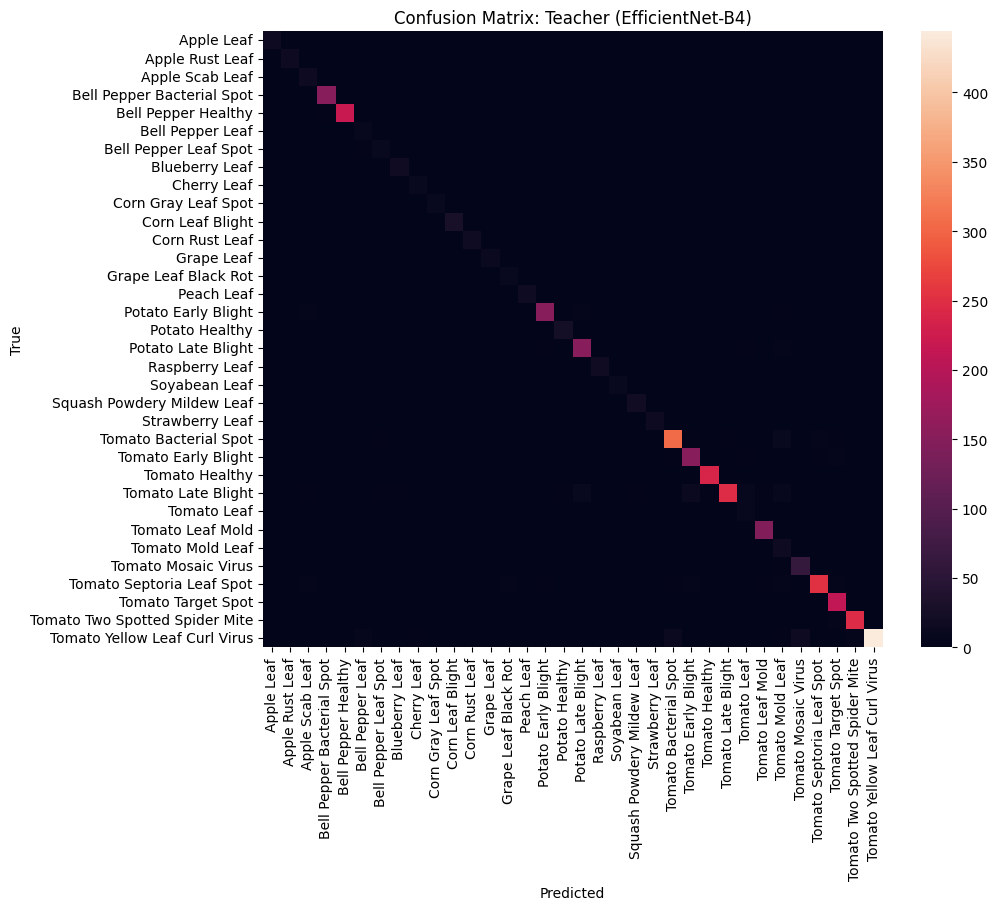

Classification Report:
Teacher (EfficientNet-B4)
                                precision    recall  f1-score   support

                    Apple Leaf       0.82      0.93      0.88        15
               Apple Rust Leaf       0.88      1.00      0.93        14
               Apple Scab Leaf       0.54      1.00      0.70        15
    Bell Pepper Bacterial Spot       0.97      1.00      0.99       151
           Bell Pepper Healthy       1.00      0.98      0.99       223
              Bell Pepper Leaf       0.44      0.80      0.57        10
         Bell Pepper Leaf Spot       0.45      0.75      0.56        12
                Blueberry Leaf       0.78      1.00      0.88        18
                   Cherry Leaf       0.83      1.00      0.91        10
           Corn Gray Leaf Spot       0.77      0.91      0.83        11
              Corn Leaf Blight       0.94      0.97      0.95        30
                Corn Rust Leaf       1.00      0.94      0.97        18
              

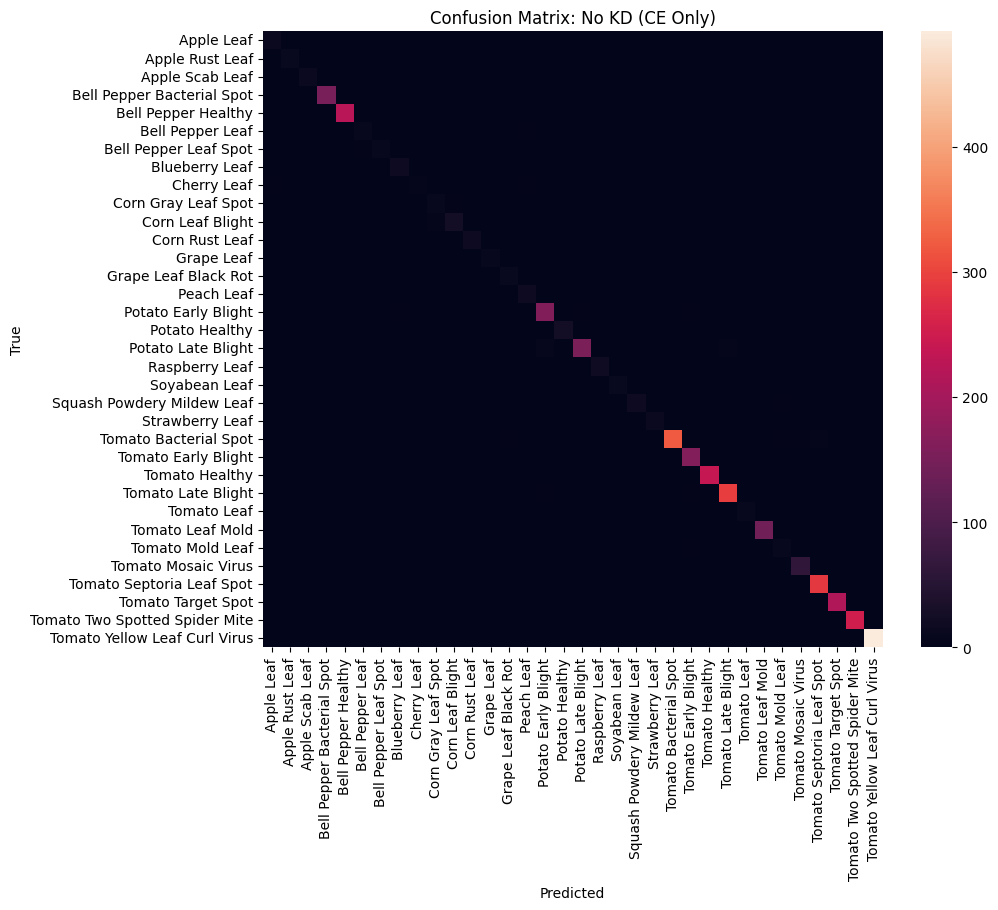

Classification Report:
No KD (CE Only)
                                precision    recall  f1-score   support

                    Apple Leaf       0.78      0.93      0.85        15
               Apple Rust Leaf       1.00      0.71      0.83        14
               Apple Scab Leaf       0.80      0.80      0.80        15
    Bell Pepper Bacterial Spot       1.00      1.00      1.00       151
           Bell Pepper Healthy       1.00      1.00      1.00       223
              Bell Pepper Leaf       0.73      0.80      0.76        10
         Bell Pepper Leaf Spot       0.80      0.67      0.73        12
                Blueberry Leaf       0.76      0.89      0.82        18
                   Cherry Leaf       1.00      0.50      0.67        10
           Corn Gray Leaf Spot       0.57      0.73      0.64        11
              Corn Leaf Blight       0.86      0.80      0.83        30
                Corn Rust Leaf       0.94      0.94      0.94        18
                    Grap

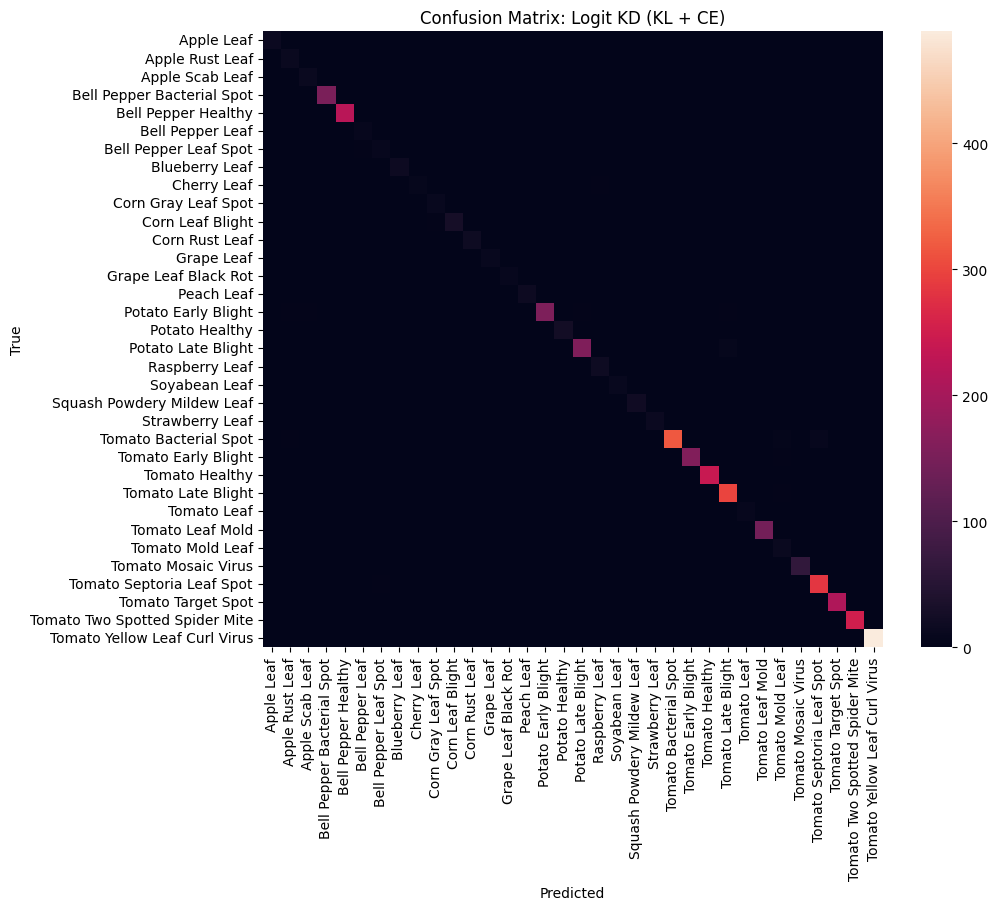

Classification Report:
Logit KD (KL + CE)
                                precision    recall  f1-score   support

                    Apple Leaf       1.00      0.93      0.97        15
               Apple Rust Leaf       0.60      0.86      0.71        14
               Apple Scab Leaf       0.68      0.87      0.76        15
    Bell Pepper Bacterial Spot       1.00      1.00      1.00       151
           Bell Pepper Healthy       1.00      1.00      1.00       223
              Bell Pepper Leaf       0.64      0.90      0.75        10
         Bell Pepper Leaf Spot       0.75      0.75      0.75        12
                Blueberry Leaf       0.94      0.94      0.94        18
                   Cherry Leaf       0.86      0.60      0.71        10
           Corn Gray Leaf Spot       0.79      1.00      0.88        11
              Corn Leaf Blight       1.00      0.90      0.95        30
                Corn Rust Leaf       0.90      1.00      0.95        18
                    G

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s]


RuntimeError: Error(s) in loading state_dict for StudentFeatureKD:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.0.block.1.fc1.weight", "features.1.0.block.1.fc1.bias", "features.1.0.block.1.fc2.weight", "features.1.0.block.1.fc2.bias", "features.1.0.block.2.0.weight", "features.1.0.block.2.1.weight", "features.1.0.block.2.1.bias", "features.1.0.block.2.1.running_mean", "features.1.0.block.2.1.running_var", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.0.block.2.fc1.weight", "features.2.0.block.2.fc1.bias", "features.2.0.block.2.fc2.weight", "features.2.0.block.2.fc2.bias", "features.2.0.block.3.0.weight", "features.2.0.block.3.1.weight", "features.2.0.block.3.1.bias", "features.2.0.block.3.1.running_mean", "features.2.0.block.3.1.running_var", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.1.block.2.fc1.weight", "features.2.1.block.2.fc1.bias", "features.2.1.block.2.fc2.weight", "features.2.1.block.2.fc2.bias", "features.2.1.block.3.0.weight", "features.2.1.block.3.1.weight", "features.2.1.block.3.1.bias", "features.2.1.block.3.1.running_mean", "features.2.1.block.3.1.running_var", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.0.block.2.fc1.weight", "features.3.0.block.2.fc1.bias", "features.3.0.block.2.fc2.weight", "features.3.0.block.2.fc2.bias", "features.3.0.block.3.0.weight", "features.3.0.block.3.1.weight", "features.3.0.block.3.1.bias", "features.3.0.block.3.1.running_mean", "features.3.0.block.3.1.running_var", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.1.block.2.fc1.weight", "features.3.1.block.2.fc1.bias", "features.3.1.block.2.fc2.weight", "features.3.1.block.2.fc2.bias", "features.3.1.block.3.0.weight", "features.3.1.block.3.1.weight", "features.3.1.block.3.1.bias", "features.3.1.block.3.1.running_mean", "features.3.1.block.3.1.running_var", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.7.0.block.0.0.weight", "features.7.0.block.0.1.weight", "features.7.0.block.0.1.bias", "features.7.0.block.0.1.running_mean", "features.7.0.block.0.1.running_var", "features.7.0.block.1.0.weight", "features.7.0.block.1.1.weight", "features.7.0.block.1.1.bias", "features.7.0.block.1.1.running_mean", "features.7.0.block.1.1.running_var", "features.7.0.block.2.fc1.weight", "features.7.0.block.2.fc1.bias", "features.7.0.block.2.fc2.weight", "features.7.0.block.2.fc2.bias", "features.7.0.block.3.0.weight", "features.7.0.block.3.1.weight", "features.7.0.block.3.1.bias", "features.7.0.block.3.1.running_mean", "features.7.0.block.3.1.running_var", "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "features.8.1.running_mean", "features.8.1.running_var", "classifier.weight", "classifier.bias", "projection.0.weight", "projection.0.bias", "projection.1.weight", "projection.1.bias", "projection.1.running_mean", "projection.1.running_var". 
	Unexpected key(s) in state_dict: "student.features.0.0.weight", "student.features.0.1.weight", "student.features.0.1.bias", "student.features.0.1.running_mean", "student.features.0.1.running_var", "student.features.0.1.num_batches_tracked", "student.features.1.0.block.0.0.weight", "student.features.1.0.block.0.1.weight", "student.features.1.0.block.0.1.bias", "student.features.1.0.block.0.1.running_mean", "student.features.1.0.block.0.1.running_var", "student.features.1.0.block.0.1.num_batches_tracked", "student.features.1.0.block.1.fc1.weight", "student.features.1.0.block.1.fc1.bias", "student.features.1.0.block.1.fc2.weight", "student.features.1.0.block.1.fc2.bias", "student.features.1.0.block.2.0.weight", "student.features.1.0.block.2.1.weight", "student.features.1.0.block.2.1.bias", "student.features.1.0.block.2.1.running_mean", "student.features.1.0.block.2.1.running_var", "student.features.1.0.block.2.1.num_batches_tracked", "student.features.2.0.block.0.0.weight", "student.features.2.0.block.0.1.weight", "student.features.2.0.block.0.1.bias", "student.features.2.0.block.0.1.running_mean", "student.features.2.0.block.0.1.running_var", "student.features.2.0.block.0.1.num_batches_tracked", "student.features.2.0.block.1.0.weight", "student.features.2.0.block.1.1.weight", "student.features.2.0.block.1.1.bias", "student.features.2.0.block.1.1.running_mean", "student.features.2.0.block.1.1.running_var", "student.features.2.0.block.1.1.num_batches_tracked", "student.features.2.0.block.2.fc1.weight", "student.features.2.0.block.2.fc1.bias", "student.features.2.0.block.2.fc2.weight", "student.features.2.0.block.2.fc2.bias", "student.features.2.0.block.3.0.weight", "student.features.2.0.block.3.1.weight", "student.features.2.0.block.3.1.bias", "student.features.2.0.block.3.1.running_mean", "student.features.2.0.block.3.1.running_var", "student.features.2.0.block.3.1.num_batches_tracked", "student.features.2.1.block.0.0.weight", "student.features.2.1.block.0.1.weight", "student.features.2.1.block.0.1.bias", "student.features.2.1.block.0.1.running_mean", "student.features.2.1.block.0.1.running_var", "student.features.2.1.block.0.1.num_batches_tracked", "student.features.2.1.block.1.0.weight", "student.features.2.1.block.1.1.weight", "student.features.2.1.block.1.1.bias", "student.features.2.1.block.1.1.running_mean", "student.features.2.1.block.1.1.running_var", "student.features.2.1.block.1.1.num_batches_tracked", "student.features.2.1.block.2.fc1.weight", "student.features.2.1.block.2.fc1.bias", "student.features.2.1.block.2.fc2.weight", "student.features.2.1.block.2.fc2.bias", "student.features.2.1.block.3.0.weight", "student.features.2.1.block.3.1.weight", "student.features.2.1.block.3.1.bias", "student.features.2.1.block.3.1.running_mean", "student.features.2.1.block.3.1.running_var", "student.features.2.1.block.3.1.num_batches_tracked", "student.features.3.0.block.0.0.weight", "student.features.3.0.block.0.1.weight", "student.features.3.0.block.0.1.bias", "student.features.3.0.block.0.1.running_mean", "student.features.3.0.block.0.1.running_var", "student.features.3.0.block.0.1.num_batches_tracked", "student.features.3.0.block.1.0.weight", "student.features.3.0.block.1.1.weight", "student.features.3.0.block.1.1.bias", "student.features.3.0.block.1.1.running_mean", "student.features.3.0.block.1.1.running_var", "student.features.3.0.block.1.1.num_batches_tracked", "student.features.3.0.block.2.fc1.weight", "student.features.3.0.block.2.fc1.bias", "student.features.3.0.block.2.fc2.weight", "student.features.3.0.block.2.fc2.bias", "student.features.3.0.block.3.0.weight", "student.features.3.0.block.3.1.weight", "student.features.3.0.block.3.1.bias", "student.features.3.0.block.3.1.running_mean", "student.features.3.0.block.3.1.running_var", "student.features.3.0.block.3.1.num_batches_tracked", "student.features.3.1.block.0.0.weight", "student.features.3.1.block.0.1.weight", "student.features.3.1.block.0.1.bias", "student.features.3.1.block.0.1.running_mean", "student.features.3.1.block.0.1.running_var", "student.features.3.1.block.0.1.num_batches_tracked", "student.features.3.1.block.1.0.weight", "student.features.3.1.block.1.1.weight", "student.features.3.1.block.1.1.bias", "student.features.3.1.block.1.1.running_mean", "student.features.3.1.block.1.1.running_var", "student.features.3.1.block.1.1.num_batches_tracked", "student.features.3.1.block.2.fc1.weight", "student.features.3.1.block.2.fc1.bias", "student.features.3.1.block.2.fc2.weight", "student.features.3.1.block.2.fc2.bias", "student.features.3.1.block.3.0.weight", "student.features.3.1.block.3.1.weight", "student.features.3.1.block.3.1.bias", "student.features.3.1.block.3.1.running_mean", "student.features.3.1.block.3.1.running_var", "student.features.3.1.block.3.1.num_batches_tracked", "student.features.4.0.block.0.0.weight", "student.features.4.0.block.0.1.weight", "student.features.4.0.block.0.1.bias", "student.features.4.0.block.0.1.running_mean", "student.features.4.0.block.0.1.running_var", "student.features.4.0.block.0.1.num_batches_tracked", "student.features.4.0.block.1.0.weight", "student.features.4.0.block.1.1.weight", "student.features.4.0.block.1.1.bias", "student.features.4.0.block.1.1.running_mean", "student.features.4.0.block.1.1.running_var", "student.features.4.0.block.1.1.num_batches_tracked", "student.features.4.0.block.2.fc1.weight", "student.features.4.0.block.2.fc1.bias", "student.features.4.0.block.2.fc2.weight", "student.features.4.0.block.2.fc2.bias", "student.features.4.0.block.3.0.weight", "student.features.4.0.block.3.1.weight", "student.features.4.0.block.3.1.bias", "student.features.4.0.block.3.1.running_mean", "student.features.4.0.block.3.1.running_var", "student.features.4.0.block.3.1.num_batches_tracked", "student.features.4.1.block.0.0.weight", "student.features.4.1.block.0.1.weight", "student.features.4.1.block.0.1.bias", "student.features.4.1.block.0.1.running_mean", "student.features.4.1.block.0.1.running_var", "student.features.4.1.block.0.1.num_batches_tracked", "student.features.4.1.block.1.0.weight", "student.features.4.1.block.1.1.weight", "student.features.4.1.block.1.1.bias", "student.features.4.1.block.1.1.running_mean", "student.features.4.1.block.1.1.running_var", "student.features.4.1.block.1.1.num_batches_tracked", "student.features.4.1.block.2.fc1.weight", "student.features.4.1.block.2.fc1.bias", "student.features.4.1.block.2.fc2.weight", "student.features.4.1.block.2.fc2.bias", "student.features.4.1.block.3.0.weight", "student.features.4.1.block.3.1.weight", "student.features.4.1.block.3.1.bias", "student.features.4.1.block.3.1.running_mean", "student.features.4.1.block.3.1.running_var", "student.features.4.1.block.3.1.num_batches_tracked", "student.features.4.2.block.0.0.weight", "student.features.4.2.block.0.1.weight", "student.features.4.2.block.0.1.bias", "student.features.4.2.block.0.1.running_mean", "student.features.4.2.block.0.1.running_var", "student.features.4.2.block.0.1.num_batches_tracked", "student.features.4.2.block.1.0.weight", "student.features.4.2.block.1.1.weight", "student.features.4.2.block.1.1.bias", "student.features.4.2.block.1.1.running_mean", "student.features.4.2.block.1.1.running_var", "student.features.4.2.block.1.1.num_batches_tracked", "student.features.4.2.block.2.fc1.weight", "student.features.4.2.block.2.fc1.bias", "student.features.4.2.block.2.fc2.weight", "student.features.4.2.block.2.fc2.bias", "student.features.4.2.block.3.0.weight", "student.features.4.2.block.3.1.weight", "student.features.4.2.block.3.1.bias", "student.features.4.2.block.3.1.running_mean", "student.features.4.2.block.3.1.running_var", "student.features.4.2.block.3.1.num_batches_tracked", "student.features.5.0.block.0.0.weight", "student.features.5.0.block.0.1.weight", "student.features.5.0.block.0.1.bias", "student.features.5.0.block.0.1.running_mean", "student.features.5.0.block.0.1.running_var", "student.features.5.0.block.0.1.num_batches_tracked", "student.features.5.0.block.1.0.weight", "student.features.5.0.block.1.1.weight", "student.features.5.0.block.1.1.bias", "student.features.5.0.block.1.1.running_mean", "student.features.5.0.block.1.1.running_var", "student.features.5.0.block.1.1.num_batches_tracked", "student.features.5.0.block.2.fc1.weight", "student.features.5.0.block.2.fc1.bias", "student.features.5.0.block.2.fc2.weight", "student.features.5.0.block.2.fc2.bias", "student.features.5.0.block.3.0.weight", "student.features.5.0.block.3.1.weight", "student.features.5.0.block.3.1.bias", "student.features.5.0.block.3.1.running_mean", "student.features.5.0.block.3.1.running_var", "student.features.5.0.block.3.1.num_batches_tracked", "student.features.5.1.block.0.0.weight", "student.features.5.1.block.0.1.weight", "student.features.5.1.block.0.1.bias", "student.features.5.1.block.0.1.running_mean", "student.features.5.1.block.0.1.running_var", "student.features.5.1.block.0.1.num_batches_tracked", "student.features.5.1.block.1.0.weight", "student.features.5.1.block.1.1.weight", "student.features.5.1.block.1.1.bias", "student.features.5.1.block.1.1.running_mean", "student.features.5.1.block.1.1.running_var", "student.features.5.1.block.1.1.num_batches_tracked", "student.features.5.1.block.2.fc1.weight", "student.features.5.1.block.2.fc1.bias", "student.features.5.1.block.2.fc2.weight", "student.features.5.1.block.2.fc2.bias", "student.features.5.1.block.3.0.weight", "student.features.5.1.block.3.1.weight", "student.features.5.1.block.3.1.bias", "student.features.5.1.block.3.1.running_mean", "student.features.5.1.block.3.1.running_var", "student.features.5.1.block.3.1.num_batches_tracked", "student.features.5.2.block.0.0.weight", "student.features.5.2.block.0.1.weight", "student.features.5.2.block.0.1.bias", "student.features.5.2.block.0.1.running_mean", "student.features.5.2.block.0.1.running_var", "student.features.5.2.block.0.1.num_batches_tracked", "student.features.5.2.block.1.0.weight", "student.features.5.2.block.1.1.weight", "student.features.5.2.block.1.1.bias", "student.features.5.2.block.1.1.running_mean", "student.features.5.2.block.1.1.running_var", "student.features.5.2.block.1.1.num_batches_tracked", "student.features.5.2.block.2.fc1.weight", "student.features.5.2.block.2.fc1.bias", "student.features.5.2.block.2.fc2.weight", "student.features.5.2.block.2.fc2.bias", "student.features.5.2.block.3.0.weight", "student.features.5.2.block.3.1.weight", "student.features.5.2.block.3.1.bias", "student.features.5.2.block.3.1.running_mean", "student.features.5.2.block.3.1.running_var", "student.features.5.2.block.3.1.num_batches_tracked", "student.features.6.0.block.0.0.weight", "student.features.6.0.block.0.1.weight", "student.features.6.0.block.0.1.bias", "student.features.6.0.block.0.1.running_mean", "student.features.6.0.block.0.1.running_var", "student.features.6.0.block.0.1.num_batches_tracked", "student.features.6.0.block.1.0.weight", "student.features.6.0.block.1.1.weight", "student.features.6.0.block.1.1.bias", "student.features.6.0.block.1.1.running_mean", "student.features.6.0.block.1.1.running_var", "student.features.6.0.block.1.1.num_batches_tracked", "student.features.6.0.block.2.fc1.weight", "student.features.6.0.block.2.fc1.bias", "student.features.6.0.block.2.fc2.weight", "student.features.6.0.block.2.fc2.bias", "student.features.6.0.block.3.0.weight", "student.features.6.0.block.3.1.weight", "student.features.6.0.block.3.1.bias", "student.features.6.0.block.3.1.running_mean", "student.features.6.0.block.3.1.running_var", "student.features.6.0.block.3.1.num_batches_tracked", "student.features.6.1.block.0.0.weight", "student.features.6.1.block.0.1.weight", "student.features.6.1.block.0.1.bias", "student.features.6.1.block.0.1.running_mean", "student.features.6.1.block.0.1.running_var", "student.features.6.1.block.0.1.num_batches_tracked", "student.features.6.1.block.1.0.weight", "student.features.6.1.block.1.1.weight", "student.features.6.1.block.1.1.bias", "student.features.6.1.block.1.1.running_mean", "student.features.6.1.block.1.1.running_var", "student.features.6.1.block.1.1.num_batches_tracked", "student.features.6.1.block.2.fc1.weight", "student.features.6.1.block.2.fc1.bias", "student.features.6.1.block.2.fc2.weight", "student.features.6.1.block.2.fc2.bias", "student.features.6.1.block.3.0.weight", "student.features.6.1.block.3.1.weight", "student.features.6.1.block.3.1.bias", "student.features.6.1.block.3.1.running_mean", "student.features.6.1.block.3.1.running_var", "student.features.6.1.block.3.1.num_batches_tracked", "student.features.6.2.block.0.0.weight", "student.features.6.2.block.0.1.weight", "student.features.6.2.block.0.1.bias", "student.features.6.2.block.0.1.running_mean", "student.features.6.2.block.0.1.running_var", "student.features.6.2.block.0.1.num_batches_tracked", "student.features.6.2.block.1.0.weight", "student.features.6.2.block.1.1.weight", "student.features.6.2.block.1.1.bias", "student.features.6.2.block.1.1.running_mean", "student.features.6.2.block.1.1.running_var", "student.features.6.2.block.1.1.num_batches_tracked", "student.features.6.2.block.2.fc1.weight", "student.features.6.2.block.2.fc1.bias", "student.features.6.2.block.2.fc2.weight", "student.features.6.2.block.2.fc2.bias", "student.features.6.2.block.3.0.weight", "student.features.6.2.block.3.1.weight", "student.features.6.2.block.3.1.bias", "student.features.6.2.block.3.1.running_mean", "student.features.6.2.block.3.1.running_var", "student.features.6.2.block.3.1.num_batches_tracked", "student.features.6.3.block.0.0.weight", "student.features.6.3.block.0.1.weight", "student.features.6.3.block.0.1.bias", "student.features.6.3.block.0.1.running_mean", "student.features.6.3.block.0.1.running_var", "student.features.6.3.block.0.1.num_batches_tracked", "student.features.6.3.block.1.0.weight", "student.features.6.3.block.1.1.weight", "student.features.6.3.block.1.1.bias", "student.features.6.3.block.1.1.running_mean", "student.features.6.3.block.1.1.running_var", "student.features.6.3.block.1.1.num_batches_tracked", "student.features.6.3.block.2.fc1.weight", "student.features.6.3.block.2.fc1.bias", "student.features.6.3.block.2.fc2.weight", "student.features.6.3.block.2.fc2.bias", "student.features.6.3.block.3.0.weight", "student.features.6.3.block.3.1.weight", "student.features.6.3.block.3.1.bias", "student.features.6.3.block.3.1.running_mean", "student.features.6.3.block.3.1.running_var", "student.features.6.3.block.3.1.num_batches_tracked", "student.features.7.0.block.0.0.weight", "student.features.7.0.block.0.1.weight", "student.features.7.0.block.0.1.bias", "student.features.7.0.block.0.1.running_mean", "student.features.7.0.block.0.1.running_var", "student.features.7.0.block.0.1.num_batches_tracked", "student.features.7.0.block.1.0.weight", "student.features.7.0.block.1.1.weight", "student.features.7.0.block.1.1.bias", "student.features.7.0.block.1.1.running_mean", "student.features.7.0.block.1.1.running_var", "student.features.7.0.block.1.1.num_batches_tracked", "student.features.7.0.block.2.fc1.weight", "student.features.7.0.block.2.fc1.bias", "student.features.7.0.block.2.fc2.weight", "student.features.7.0.block.2.fc2.bias", "student.features.7.0.block.3.0.weight", "student.features.7.0.block.3.1.weight", "student.features.7.0.block.3.1.bias", "student.features.7.0.block.3.1.running_mean", "student.features.7.0.block.3.1.running_var", "student.features.7.0.block.3.1.num_batches_tracked", "student.features.8.0.weight", "student.features.8.1.weight", "student.features.8.1.bias", "student.features.8.1.running_mean", "student.features.8.1.running_var", "student.features.8.1.num_batches_tracked", "student.classifier.1.weight", "student.classifier.1.bias", "proj.weight", "proj.bias". 

In [ ]:
# Teacher
evaluate_model("/content/efficientnet_b4_plant_disease.pth", lambda nc: efficientnet_b4(weights=None, num_classes=nc), "Teacher (EfficientNet-B4)")

# No KD
evaluate_model("/content/student_ce_onlywithout.pth", lambda nc: efficientnet_b0(weights=None, num_classes=nc), "No KD (CE Only)")

# Logit KD
evaluate_model("/content/student_kl_ce.pth", lambda nc: efficientnet_b0(weights=None, num_classes=nc), "Logit KD (KL + CE)")

# Feature+CE (Custom Student)
class StudentFeatureKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)
        self.projection = nn.Sequential(
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

evaluate_model("/content/student_feature_ce.pth", StudentFeatureKD, "Feature + CE")

# Attention+CE (Custom)
class StudentAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

evaluate_model("/content/student_attention_ce (2).pth", StudentAttentionKD, "Attention + CE")

# RKD+CE (Custom)
class StudentRKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

evaluate_model("/content/student_rkd_ce.pth", StudentRKD, "RKD + CE")


In [ ]:
ckpt = torch.load("/content/student_feature_ce.pth", map_location="cpu")
print(ckpt.keys())


dict_keys(['model_state_dict', 'class_to_idx'])



✅ Test Accuracy: 94.83%

📄 Classification Report:

                                precision    recall  f1-score   support

                    Apple Leaf       1.00      0.60      0.75        15
               Apple Rust Leaf       0.93      1.00      0.97        14
               Apple Scab Leaf       0.93      0.93      0.93        15
    Bell Pepper Bacterial Spot       0.99      1.00      0.99       151
           Bell Pepper Healthy       1.00      1.00      1.00       223
              Bell Pepper Leaf       0.59      1.00      0.74        10
         Bell Pepper Leaf Spot       0.56      0.75      0.64        12
                Blueberry Leaf       0.65      0.94      0.77        18
                   Cherry Leaf       1.00      0.70      0.82        10
           Corn Gray Leaf Spot       0.62      0.91      0.74        11
              Corn Leaf Blight       0.92      0.73      0.81        30
                Corn Rust Leaf       0.78      0.78      0.78        18
           

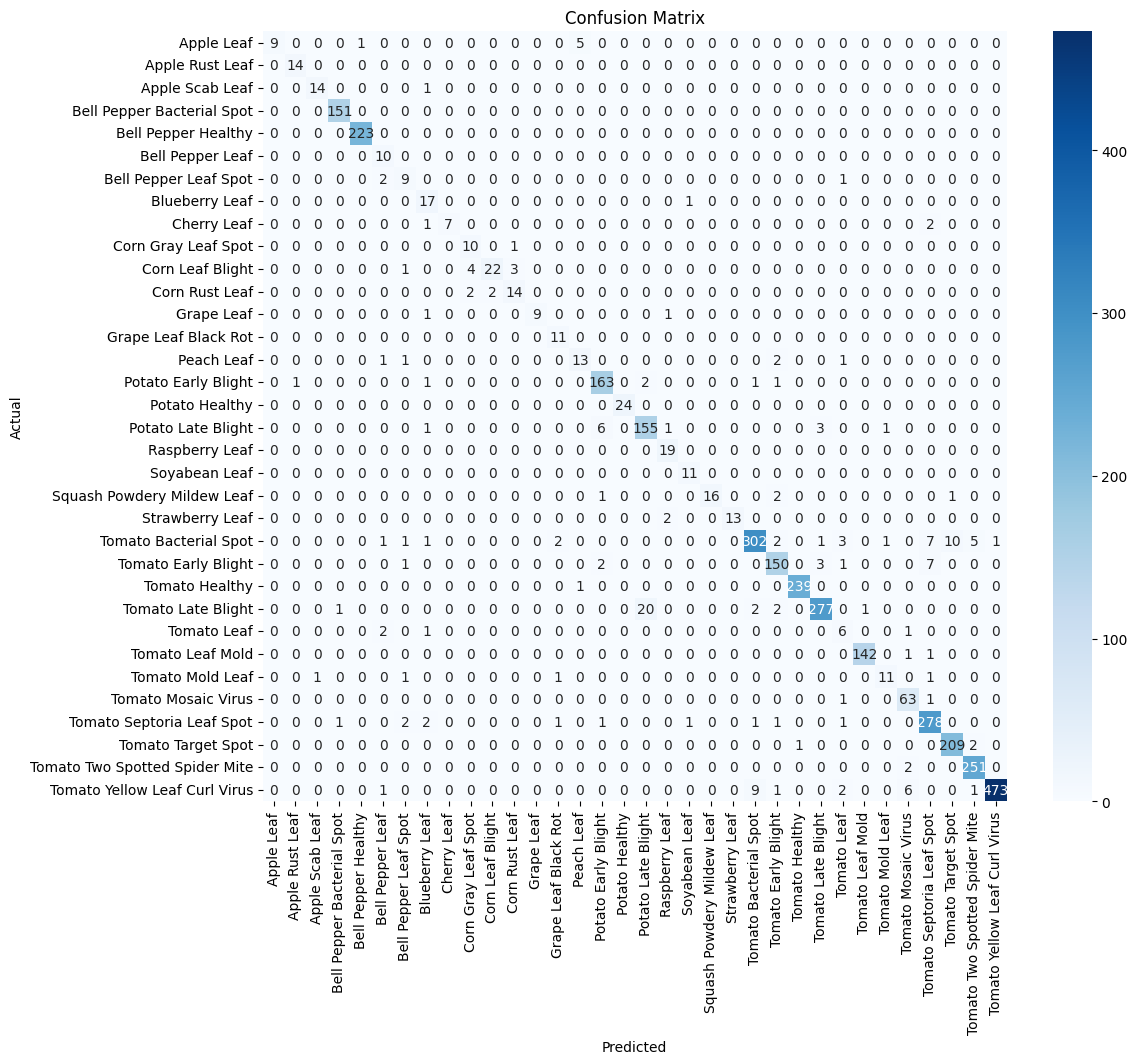

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define class ===
class StudentWithProjection(nn.Module):
    def __init__(self, num_classes, teacher_feature_channels):
        super().__init__()
        self.student = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.student.classifier[1] = nn.Linear(self.student.classifier[1].in_features, num_classes)
        self.proj = nn.Conv2d(self.student.features[6][0].out_channels, teacher_feature_channels, kernel_size=1)

    def forward(self, x):
        feats = self.student.features[:7](x)          # Used during training
        proj_feats = self.proj(feats)                 # Used during training
        logits = self.student(x)                      # Final prediction
        return logits

# === Define dataset transforms ===
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load Test Data ===
test_dir = "/content/PlantDatasetSplit3Way/test"  # Update this if needed
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Load model and weights ===
checkpoint = torch.load("/content/student_feature_ce.pth", map_location=DEVICE)
class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

teacher_feature_channels = 272  # As seen from training logs or .pth file

model = StudentWithProjection(num_classes, teacher_feature_channels).to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# === Evaluation ===
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        logits = model(images)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Accuracy ===
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%")

# === Classification Report ===
print("\n📄 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[idx_to_class[i] for i in range(num_classes)],
            yticklabels=[idx_to_class[i] for i in range(num_classes)], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:


!pip install ptflops

import torch
import torch.nn as nn
import time
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B4_Weights, EfficientNet_B0_Weights
from ptflops import get_model_complexity_info
from PIL import Image
import random

DEVICE_CPU = torch.device("cpu")
DEVICE_GPU = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 288
NUM_CLASSES = 38 # Adjust if different
TEST_SAMPLE_COUNT = 30
TEST_DIR = "./PlantDatasetSplit3Way/test"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import time
import torch
import torchvision
import numpy as np
from ptflops import get_model_complexity_info
from torchvision.models import efficientnet_b0, efficientnet_b4, EfficientNet_B0_Weights, EfficientNet_B4_Weights
from torchvision import transforms
from PIL import Image
import pandas as pd

# Device setup
DEVICE_GPU = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE_CPU = torch.device("cpu")

# Adjust based on your input size
IMG_SIZE = 300
NUM_CLASSES = 34  # change if needed
TEST_SAMPLE_COUNT = 30

# Sample dummy input for FLOPs
dummy_input = (3, IMG_SIZE, IMG_SIZE)

# === Replace with your actual student classes if needed ===
class StudentFeatureKD(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.student = torch.nn.Sequential(*list(base.children())[:-1])
        self.fc = torch.nn.Linear(base.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.student(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

class StudentAttentionKD(StudentFeatureKD): pass  # Replace if structurally different
class StudentRKD(StudentFeatureKD): pass  # Replace if structurally different

# === Helper to load sample images ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def load_test_images(n):
    dummy_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='white')
    return [transform(dummy_img) for _ in range(n)]

images = load_test_images(TEST_SAMPLE_COUNT)

# === Core Benchmark Function ===
def benchmark_model(model_name, model_fn, checkpoint_path):
    print(f"\n🚀 Benchmarking: {model_name}")

    model = model_fn(NUM_CLASSES).to(DEVICE_GPU)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE_GPU)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Params
    total_params = sum(p.numel() for p in model.parameters())

    # File Size
    file_size_mb = os.path.getsize(checkpoint_path) / 1e6

    # FLOPs
    flops, _ = get_model_complexity_info(model, dummy_input, as_strings=False, print_per_layer_stat=False)

    # Latency (mean over TEST_SAMPLE_COUNT)
    def measure_latency(device):
        model.to(device)
        torch.cuda.empty_cache()
        times = []
        with torch.no_grad():
            for img in images:
                x = img.unsqueeze(0).to(device)
                start = time.time()
                _ = model(x)
                end = time.time()
                times.append((end - start) * 1000)
        return np.mean(times)

    latency_gpu = measure_latency(DEVICE_GPU)
    latency_cpu = measure_latency(DEVICE_CPU)

    return {
        "Model": model_name,
        "Params (M)": round(total_params / 1e6, 2),
        "Size (MB)": round(file_size_mb, 2),
        "FLOPs (GFLOPs)": round(flops / 1e9, 2),
        "Latency GPU (ms)": round(latency_gpu, 2),
        "Latency CPU (ms)": round(latency_cpu, 2)
    }

# === Define model loaders ===
def get_teacher(nc):
    model = efficientnet_b4(weights=None)
    # Temporarily allow flexible output layer to load weights
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, nc)
    return model

def get_student_b0(nc):
    model = efficientnet_b0(weights=None)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, nc)
    return model

# === Benchmark All Models ===
results = []

results.append(benchmark_model("Teacher (Eff-B4)", get_teacher, "/content/efficientnet_b4_plant_disease.pth"))
results.append(benchmark_model("No KD (CE Only)", get_student_b0, "/content/student_ce_onlywithout.pth"))
results.append(benchmark_model("Logit KD (KL+CE)", get_student_b0, "/content/student_kl_ce.pth"))
results.append(benchmark_model("Feature + CE", lambda nc: StudentFeatureKD(nc), "/content/student_feature_ce.pth"))
results.append(benchmark_model("Attention + CE", lambda nc: StudentAttentionKD(nc), "/content/student_attention_ce.pth"))
results.append(benchmark_model("RKD + CE", lambda nc: StudentRKD(nc), "/content/student_rkd_ce.pth"))

# === Output as Table ===
df = pd.DataFrame(results)
print("\n📊 Model Efficiency Comparison:\n")
print(df)



🚀 Benchmarking: Teacher (Eff-B4)

🚀 Benchmarking: No KD (CE Only)

🚀 Benchmarking: Logit KD (KL+CE)

🚀 Benchmarking: Feature + CE


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 



🚀 Benchmarking: Attention + CE

🚀 Benchmarking: RKD + CE

📊 Model Efficiency Comparison:

              Model  Params (M)  Size (MB)  FLOPs (GFLOPs)  Latency GPU (ms)  \
0  Teacher (Eff-B4)       17.61      71.21            2.98            260.82   
1   No KD (CE Only)        4.05      16.51            0.77             85.15   
2  Logit KD (KL+CE)        4.05      16.51            0.77             82.26   
3      Feature + CE        4.05      16.72            0.77             84.90   
4    Attention + CE        4.05      21.70            0.77             90.80   
5          RKD + CE        4.05      16.51            0.77             84.59   

   Latency CPU (ms)  
0            280.18  
1             84.17  
2            114.03  
3             89.32  
4            116.82  
5             94.20  


severity

In [ ]:
# === SETUP ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/student_attention_ce (2).pth"  # Your uploaded model

# === Define StudentAttentionKD model ===
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class StudentAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.student = efficientnet_b0(weights=None)
        self.student.classifier[1] = nn.Linear(self.student.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.student(x)
def load_student_model(path):
    checkpoint = torch.load(path, map_location=DEVICE)
    class_to_idx = checkpoint['class_to_idx']
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)

    from torchvision.models import efficientnet_b0
    model = efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    raw_state = checkpoint['model_state_dict']

    # Fix classifier key mismatch if needed
    new_state = {}
    for k, v in raw_state.items():
        if k == "classifier.weight":
            new_state["classifier.1.weight"] = v
        elif k == "classifier.bias":
            new_state["classifier.1.bias"] = v
        elif k.startswith("efficientnet."):
            new_state[k.replace("efficientnet.", "")] = v
        else:
            new_state[k] = v

    model.load_state_dict(new_state, strict=True)

    class WrappedStudent(nn.Module):
        def __init__(self, core_model):
            super().__init__()
            self.student = core_model

        def forward(self, x):
            return self.student(x)

    wrapped = WrappedStudent(model).to(DEVICE)
    wrapped.eval()
    return wrapped, idx_to_class




# === Preprocessing ===
transform = T.Compose([
    T.Resize((300, 300)),
    T.CenterCrop(288),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# === Severity Function ===
def estimate_severity(prob, thresholds=(0.6, 0.85)):
    if prob < thresholds[0]:
        return "early"
    elif prob < thresholds[1]:
        return "moderate"
    else:
        return "severe"

# === Inference ===
def predict_image(img_path, model, idx_to_class, topk=5):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)[0]
        top_probs, top_idxs = probs.topk(topk)
        top_probs = top_probs.cpu().numpy()
        top_idxs = top_idxs.cpu().numpy()

    print("🔍 Top Predictions:")
    for i in range(topk):
        cls = idx_to_class[top_idxs[i]]
        conf = top_probs[i]
        print(f"{i+1}. {cls:35s} — {conf:.4f}")

    pred_class = idx_to_class[top_idxs[0]]
    severity = estimate_severity(top_probs[0])

    print(f"\n🌿 Predicted Class: {pred_class}")
    print(f"📊 Confidence: {top_probs[0]:.4f}")
    print(f"🔥 Estimated Severity: {severity}")

    # Visualize
    plt.imshow(img)
    plt.title(f"{pred_class}\nConfidence: {top_probs[0]:.2f}  |  Severity: {severity}")
    plt.axis('off')
    plt.show()

# === Run ===
model, idx_to_class = load_student_model(MODEL_PATH)

# 🔁 Example usage: Change to your test image path
predict_image("/content/PlantDatasetSplit3Way/test/Corn Rust Leaf/plantdoc_0796.40comrust.jpg", model, idx_to_class)


In [ ]:
# === SETUP ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/student_attention_ce (2).pth"  # Your uploaded model

# === Define StudentAttentionKD model ===
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class StudentAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.student = efficientnet_b0(weights=None)
        self.student.classifier[1] = nn.Linear(self.student.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.student(x)
def load_student_model(path):
    checkpoint = torch.load(path, map_location=DEVICE)
    class_to_idx = checkpoint['class_to_idx']
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)

    from torchvision.models import efficientnet_b0
    model = efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    raw_state = checkpoint['model_state_dict']

    # Fix classifier key mismatch if needed
    new_state = {}
    for k, v in raw_state.items():
        if k == "classifier.weight":
            new_state["classifier.1.weight"] = v
        elif k == "classifier.bias":
            new_state["classifier.1.bias"] = v
        elif k.startswith("efficientnet."):
            new_state[k.replace("efficientnet.", "")] = v
        else:
            new_state[k] = v

    model.load_state_dict(new_state, strict=True)

    class WrappedStudent(nn.Module):
        def __init__(self, core_model):
            super().__init__()
            self.student = core_model

        def forward(self, x):
            return self.student(x)

    wrapped = WrappedStudent(model).to(DEVICE)
    wrapped.eval()
    return wrapped, idx_to_class




# === Preprocessing ===
transform = T.Compose([
    T.Resize((300, 300)),
    T.CenterCrop(288),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def estimate_severity(class_name, confidence):
    healthy_keywords = ["healthy", "healthy leaf", "no disease"]
    class_lower = class_name.lower()

    if any(word in class_lower for word in healthy_keywords):
        return "healthy"

    if confidence > 0.85:
        return "severe"
    elif confidence > 0.5:
        return "moderate"
    else:
        return "early"


# === Inference ===
def predict_image(img_path, model, idx_to_class, topk=5):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)[0]
        top_probs, top_idxs = probs.topk(topk)
        top_probs = top_probs.cpu().numpy()
        top_idxs = top_idxs.cpu().numpy()

    print("🔍 Top Predictions:")
    for i in range(topk):
        cls = idx_to_class[top_idxs[i]]
        conf = top_probs[i]
        print(f"{i+1}. {cls:35s} — {conf:.4f}")

    pred_class = idx_to_class[top_idxs[0]]
    severity = estimate_severity(pred_class, top_probs[0])

    print(f"\n🌿 Predicted Class: {pred_class}")
    print(f"📊 Confidence: {top_probs[0]:.4f}")
    print(f"🔥 Estimated Severity: {severity}")

    # Visualize
    plt.imshow(img)
    plt.title(f"{pred_class}\nConfidence: {top_probs[0]:.2f}  |  Severity: {severity}")
    plt.axis('off')
    plt.show()

# === Run ===
model, idx_to_class = load_student_model(MODEL_PATH)

# 🔁 Example usage: Change to your test image path
predict_image("/content/PlantDatasetSplit3Way/test/Bell Pepper Healthy/plantvillage_02a7d2e5-9169-4856-9683-d4fa9894e012___JR_HL 8002.JPG", model, idx_to_class)

attention map

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import efficientnet_b4, efficientnet_b0, EfficientNet_B0_Weights, EfficientNet_B4_Weights
from PIL import Image
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define the same student architecture you used ===
class StudentAttentionKD(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        self.classifier = torch.nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x, return_features=False):
        feats = self.features[:8](x)
        if return_features:
            return feats
        x = self.features[8:](feats)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# === Attention Map Function ===
def compute_attention_map(features):
    att = torch.sum(features ** 2, dim=1, keepdim=True)
    att = F.interpolate(att, size=(288, 288), mode='bilinear', align_corners=False)
    att = att.squeeze().cpu().numpy()
    att = (att - att.min()) / (att.max() - att.min() + 1e-8)
    return att

# === Load Models ===
NUM_CLASSES = 34  # change if different
student_ckpt = torch.load('/content/student_attention_ce (2).pth', map_location=DEVICE)
class_to_idx = student_ckpt['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

student = StudentAttentionKD(NUM_CLASSES).to(DEVICE)
student.load_state_dict(student_ckpt['model_state_dict'])
student.eval()

teacher = efficientnet_b4(weights=None)
teacher.classifier[1] = torch.nn.Linear(teacher.classifier[1].in_features, NUM_CLASSES)
teacher_ckpt = torch.load('/content/efficientnet_b4_plant_disease.pth', map_location=DEVICE)
teacher.load_state_dict(teacher_ckpt['model_state_dict'])
teacher.eval().to(DEVICE)

# === Image Transforms ===
transform = T.Compose([
    T.Resize((300, 300)),
    T.CenterCrop(288),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

# === Load and preprocess test image ===
image_path = "/content/PlantDatasetSplit3Way/test/Bell Pepper Bacterial Spot/plantvillage_018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Spot 9045.JPG"  # <- change this path to your image
original = Image.open(image_path).convert("RGB")
image = transform(original).unsqueeze(0).to(DEVICE)

# === Extract and visualize attention ===
with torch.no_grad():
    student_features = student(image, return_features=True)
    teacher_features = teacher.features[:8](image)

student_attn = compute_attention_map(student_features)
teacher_attn = compute_attention_map(teacher_features)

def overlay_attention(original, attn, cmap='jet'):
    original_np = np.array(original.resize((288, 288))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * attn), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255.0
    overlayed = heatmap * 0.5 + original_np * 0.5
    return np.clip(overlayed, 0, 1)

# === Plot ===
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(original.resize((288, 288)))
axs[0].set_title("Input Image")
axs[1].imshow(overlay_attention(original, teacher_attn))
axs[1].set_title("Teacher Attention")
axs[2].imshow(overlay_attention(original, student_attn))
axs[2].set_title("Student Attention")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


accuracy curves

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

# Teacher logs
teacher_train_acc = [0.4115, 0.6978, 0.8017, 0.8523, 0.8845, 0.9080, 0.9234, 0.9358, 0.9454, 0.9502]
teacher_val_acc   = [0.4203, 0.7110, 0.7846, 0.8112, 0.8580, 0.8822, 0.9013, 0.8984, 0.9154, 0.9235]
teacher_train_loss = [1.8184, 1.0582, 0.8700, 0.7817, 0.7417, 0.7150, 0.7011, 0.6935, 0.6649, 0.6651]
teacher_val_loss   = [6.8852, 6.3963, 6.1398, 5.9338, 5.7952, 5.6481, 5.5755, 5.5350, 5.4528, 5.4020]

# Student (Attention+CE) logs
student_train_acc = [0.7160, 0.9013, 0.9386, 0.9497, 0.9582, 0.9637, 0.9669, 0.9722, 0.9717, 0.9750]
student_val_acc   = [0.9128, 0.9420, 0.9405, 0.9446, 0.9501, 0.9492, 0.9440, 0.9518, 0.9541, 0.9564]
student_train_loss = [1.1001, 0.3718, 0.2401, 0.1904, 0.1572, 0.1382, 0.1208, 0.1031, 0.0977, 0.0870]
student_val_loss   = [0.3011, 0.2079, 0.2222, 0.2141, 0.1930, 0.1998, 0.2195, 0.2015, 0.2010, 0.1870]

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, teacher_train_acc, '--o', label='Teacher Train Acc')
plt.plot(epochs, teacher_val_acc, '-o', label='Teacher Val Acc')
plt.plot(epochs, student_train_acc, '--s', label='Student Train Acc')
plt.plot(epochs, student_val_acc, '-s', label='Student Val Acc')
plt.title('📈 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, teacher_train_loss, '--o', label='Teacher Train Loss')
plt.plot(epochs, teacher_val_loss, '-o', label='Teacher Val Loss')
plt.plot(epochs, student_train_loss, '--s', label='Student Train Loss')
plt.plot(epochs, student_val_loss, '-s', label='Student Val Loss')
plt.title('📉 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


feature map

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from torchvision.models import efficientnet_b4, efficientnet_b0
from torchvision.models import EfficientNet_B4_Weights, EfficientNet_B0_Weights
from albumentations.pytorch import ToTensorV2
import albumentations as A

# === CONFIG ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_PATH = "/content/PlantDatasetSplit3Way/test/Tomato Two Spotted Spider Mite/plantvillage_14ad9c80-2dcc-4ed3-85d8-84e5621af8ae___Com.G_SpM_FL 1276.JPG"  # Change as needed
IMG_SIZE = 300
CHECKPOINT_TEACHER = "/content/efficientnet_b4_plant_disease.pth"
CHECKPOINT_STUDENT = "/content/student_attention_ce (2).pth"

# === Transform ===
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(288, 288),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def preprocess(img_path):
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return None
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image)
    return augmented['image'].unsqueeze(0).to(DEVICE)

# === Hook Utility ===
def register_hook(model, layer_name, feature_container):
    for name, module in model.named_modules():
        if name == layer_name:
            def hook_fn(_, __, output):
                feature_container['feat'] = output.detach()
            module.register_forward_hook(hook_fn)
            break

# === Load Teacher ===
teacher = efficientnet_b4(weights=None)
teacher.classifier[1] = nn.Linear(teacher.classifier[1].in_features, 34)
teacher_ckpt = torch.load(CHECKPOINT_TEACHER, map_location=DEVICE)
teacher.load_state_dict(teacher_ckpt['model_state_dict'])
teacher.to(DEVICE).eval()

# === Load Student ===
class StudentForAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = efficientnet_b0(weights=None)
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.features[:8](x)
        # Store features in the container (assuming feat_student is accessible here)
        # This requires feat_student to be defined in a scope accessible by the forward method
        # A more robust approach is to pass the container or access it via a class member if StudentForAttentionKD
        # were part of a larger training class. For this notebook context, we'll assume direct access
        # to the globally defined feat_student dictionary is intended for demonstration.
        # NOTE: In a real training loop, you would manage feature storage differently.
        global feat_student # Declare feat_student as global to modify it
        feat_student['feat'] = features.detach()

        if return_features:
            return features

        x = self.features[8:](features)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

student = StudentForAttentionKD(num_classes=34)
student_ckpt = torch.load(CHECKPOINT_STUDENT, map_location=DEVICE)
student.load_state_dict(student_ckpt['model_state_dict'])
student.to(DEVICE).eval()

# === Register Hooks ===
# Redefine feat_teacher and feat_student to ensure they are global dictionaries
feat_teacher = {}
feat_student = {} # This is crucial: ensure feat_student is an empty dict before forward passes

register_hook(teacher, "features.7", feat_teacher)
# The student hook is now less critical for feature extraction in this setup
# since features are stored directly in the forward pass, but keeping it might
# be useful for other debugging/visualization purposes if needed.
# If the direct storage in forward is used, this student hook might become redundant for 'feat'.
# However, let's keep it as it was, the primary fix is in the forward method.
register_hook(student, "features.7", feat_student)


# === Forward Pass ===
image_tensor = preprocess(IMG_PATH)
if image_tensor is not None:
    # Ensure feat_teacher is reset before teacher forward pass
    feat_teacher = {}
    register_hook(teacher, "features.7", feat_teacher) # Re-register hook to ensure it's active
    _ = teacher(image_tensor)


    # Ensure feat_student is reset before student forward pass
    feat_student = {} # Reset for the student pass
    # No need to re-register student hook if features are stored directly in forward()
    # However, if you prefer using hooks, the forward method should not return early
    # when return_features is True if you want the hook to always fire on features.7.
    # Let's rely on the direct storage in forward for simplicity in this fix.
    _ = student(image_tensor) # Perform student forward pass

    # === Visualization ===
    def plot_feature_maps(tensor, title, num_maps=6):
        tensor = tensor.squeeze(0).cpu()
        # Handle cases where feature maps might have fewer than num_maps channels
        num_maps_to_plot = min(num_maps, tensor.shape[0])
        if num_maps_to_plot == 0:
            print(f"Warning: No feature maps available to plot for {title}")
            return

        fig, axes = plt.subplots(1, num_maps_to_plot, figsize=(15, 5))
        # Ensure axes is always iterable, even with 1 subplot
        if num_maps_to_plot == 1:
            axes = [axes]

        for i in range(num_maps_to_plot):
            axes[i].imshow(tensor[i].numpy(), cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Map {i}")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    # Now access the stored features
    if 'feat' in feat_teacher:
        plot_feature_maps(feat_teacher['feat'], "👨‍🏫 Teacher Feature Maps")
    else:
        print("Teacher features not captured.")

    if 'feat' in feat_student:
        plot_feature_maps(feat_student['feat'], "👩‍🎓 Student Feature Maps")
    else:
         print("Student features not captured.")

else:
    print("Skipping feature map visualization due to image loading error.")

Newly added


In [ ]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, classification_report

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
test_dir = './PlantDatasetSplit3Way/test'
model_path = '/content/student_feature_ce.pth'


In [ ]:
class StudentAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the same student class as used during training
class StudentForAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = efficientnet_b0(weights=None)  # no pretrained weights
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.features[:8](x)  # up to block7
        if return_features:
            return features
        x = self.features[8:](features)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# load the checkpoint
attention_ce_model_path = '/content/student_attention_ce.pth'
checkpoint = torch.load(attention_ce_model_path, map_location=DEVICE)

# extract class_to_idx and infer num_classes
class_to_idx = checkpoint.get('class_to_idx')
num_classes = len(class_to_idx)

# instantiate the model
model = StudentForAttentionKD(num_classes).to(DEVICE)

# load weights
state_dict = checkpoint.get('model_state_dict', checkpoint)
missing, unexpected = model.load_state_dict(state_dict, strict=False)

print(f"✅ Model loaded: {len(missing)} missing, {len(unexpected)} unexpected keys")
model.eval()
print("✅ Model ready on", DEVICE)


In [ ]:
all_preds = []
all_labels = []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing Attention+CE"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"\n✅ Attention+CE Test Accuracy: {accuracy:.4f}")


In [ ]:
all_preds = []
all_labels = []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing Attention+CE"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"\n✅ Attention+CE Test Accuracy: {accuracy:.4f}")


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.title(f'Confusion Matrix: Attention+CE')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
class StudentRKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = base.avgpool
        self.classifier = nn.Linear(base.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [ ]:
import torchvision

student_rkd = StudentRKD(num_classes).to(DEVICE)
ckpt = torch.load("/content/student_rkd_ce.pth", map_location=DEVICE)
student_rkd.load_state_dict(ckpt['model_state_dict'])
student_rkd.eval()

print("✅ RKD+CE Model loaded & ready")



In [ ]:
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = student_rkd(x)
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = (all_preds == all_labels).mean()
print(f"🎯 RKD+CE Test Accuracy: {acc*100:.2f}%")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: RKD+CE")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys())))

In [ ]:
import time
import os
from ptflops import get_model_complexity_info

def benchmark_model(model, example_input):
    model.eval()
    start = time.time()
    with torch.no_grad():
        _ = model(example_input)
    end = time.time()
    latency = end - start

    params = sum(p.numel() for p in model.parameters()) / 1e6
    size_mb = os.path.getsize("model.pth") / 1e6

    macs, params_flops = get_model_complexity_info(model, (3, 288, 288), as_strings=True, print_per_layer_stat=False)
    print(f"Latency: {latency:.4f}s | Params: {params:.2f}M | Size: {size_mb:.2f}MB | FLOPs: {macs}")


In [ ]:
import matplotlib.pyplot as plt

methods = ['Logit', 'Feature', 'Attention', 'RKD']
ce_acc = [95.1, 95.7, 95.6, 78.6]
nce_acc = [78, 3.1, 1.2, 0.5]  # replace with your actual no-CE results

x = np.arange(len(methods))
plt.bar(x-0.2, nce_acc, 0.4, label='KD Only')
plt.bar(x+0.2, ce_acc, 0.4, label='KD + CE')
plt.xticks(x, methods)
plt.ylabel('Accuracy (%)')
plt.title('Ablation: CE vs No-CE')
plt.legend()
plt.show()


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# ✅ Example data
y_true = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
y_pred_baseline = [0, 1, 0, 0, 1, 1, 1, 1, 0, 0]  # predictions from baseline
y_pred_attention = [0, 1, 1, 1, 1, 0, 1, 1, 0, 1]  # predictions from attention-based model

# Compute correct/incorrect binary
correct_baseline = np.array(y_true) == np.array(y_pred_baseline)
correct_attention = np.array(y_true) == np.array(y_pred_attention)

b01 = np.sum((correct_baseline == 0) & (correct_attention == 1))  # baseline wrong, attention correct
b10 = np.sum((correct_baseline == 1) & (correct_attention == 0))  # baseline correct, attention wrong

table = [[0, b01], [b10, 0]]

result = mcnemar(table, exact=False, correction=True)

print(f"Contingency table: {table}")
print(f"McNemar’s test statistic: {result.statistic:.4f}")
print(f"McNemar’s test p-value: {result.pvalue:.4f}")


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.features[-1]  # Adjust to your model
cam = GradCAM(model=model, target_layers=[target_layer])

for x, y in test_loader:
    grayscale_cam = cam(input_tensor=x.to(DEVICE), targets=[ClassifierOutputTarget(y[0].item())])
    visualization = show_cam_on_image(x[0].permute(1,2,0).cpu().numpy()/255.0, grayscale_cam[0], use_rgb=True)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.show()
    break


In [ ]:
import torch
import os
import time
from ptflops import get_model_complexity_info

def benchmark_model(model, input_size=(3, 288, 288), model_path="model.pth"):
    model.eval()

    # Generate dummy input for latency benchmarking
    example_input = torch.randn(1, *input_size).to(next(model.parameters()).device)

    # Latency measurement
    start_time = time.time()
    with torch.no_grad():
        _ = model(example_input)
    latency = time.time() - start_time

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters()) / 1e6  # in Millions

    # File size
    if os.path.exists(model_path):
        model_size = os.path.getsize(model_path) / 1e6  # in MB
    else:
        model_size = 0

    # FLOPs (Multiply–accumulate operations)
    macs, _ = get_model_complexity_info(model, input_res=input_size, as_strings=True,
                                        print_per_layer_stat=False)

    print("📊 Benchmark Report:")
    print(f"• Latency: {latency:.4f} seconds")
    print(f"• Parameters: {total_params:.2f} Million")
    print(f"• Model Size: {model_size:.2f} MB ({model_path})")
    print(f"• FLOPs: {macs}")



In [ ]:
import torch
import os
import time
from ptflops import get_model_complexity_info
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def benchmark_model(model, input_size=(3, 288, 288), model_path="model.pth"):
    model = model.to('cpu')  # ptflops expects model on CPU
    model.eval()

    # Latency measurement
    example_input = torch.randn(1, *input_size)
    start_time = time.time()
    with torch.no_grad():
        _ = model(example_input)
    latency = time.time() - start_time

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters()) / 1e6  # in Millions

    # File size
    if os.path.exists(model_path):
        model_size = os.path.getsize(model_path) / 1e6  # in MB
    else:
        model_size = 0

    # FLOPs
    macs, _ = get_model_complexity_info(model, input_res=input_size, as_strings=True, print_per_layer_stat=False)

    print("📊 Benchmark Report:")
    print(f"• Latency: {latency:.4f} seconds")
    print(f"• Parameters: {total_params:.2f} Million")
    print(f"• Model Size: {model_size:.2f} MB ({model_path})")
    print(f"• FLOPs: {macs}")

# ✅ Load a model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# ✅ Save the model temporarily (optional, for size reporting)
torch.save(model.state_dict(), "temp_model.pth")

# ✅ Run the benchmark
benchmark_model(model, model_path="temp_model.pth")



In [ ]:
import os

data_dir = "/content/PlantDatasetSplit3Way/test"  # update path if needed
class_names = sorted(os.listdir(data_dir))
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)


In [ ]:
DEVICE = torch.device("cpu")


In [ ]:
model.to(DEVICE)


In [ ]:
!pip install thop


In [ ]:
import torch
import os
import time
from ptflops import get_model_complexity_info
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def benchmark_model(model, input_size=(3, 288, 288), model_path="model.pth", runs=50):
    DEVICE = torch.device("cpu")
    model = model.to(DEVICE)
    model.eval()

    example_input = torch.randn(1, *input_size).to(DEVICE)

    # 🕒 Latency measurement (averaged)
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start_time = time.time()
            _ = model(example_input)
            times.append(time.time() - start_time)
    avg_latency = sum(times) / len(times)

    # 📦 Parameter count
    total_params = sum(p.numel() for p in model.parameters()) / 1e6  # in Millions

    # 💾 File size
    if os.path.exists(model_path):
        model_size = os.path.getsize(model_path) / 1e6  # in MB
    else:
        model_size = 0

    # 🧮 FLOPs
    macs, _ = get_model_complexity_info(model, input_res=input_size, as_strings=True, print_per_layer_stat=False)

    # 📊 Report
    print("📊 CPU Benchmark Report:")
    print(f"• Avg Latency: {avg_latency:.4f} sec (over {runs} runs)")
    print(f"• Parameters: {total_params:.2f} Million")
    print(f"• Model Size: {model_size:.2f} MB ({model_path})")
    print(f"• FLOPs: {macs}")

# ✅ Load model and weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# ✅ Save model temporarily for size check
torch.save(model.state_dict(), "temp_model.pth")

# ✅ Run benchmark on CPU
benchmark_model(model, input_size=(3, 288, 288), model_path="temp_model.pth")


In [ ]:
import torch
import time
import os
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from ptflops import get_model_complexity_info

def benchmark_model_batch(model, input_size=(3, 288, 288), model_path="model.pth", device='cpu'):
    model = model.to(device).eval()

    batch_size = 30
    dummy_input = torch.randn(batch_size, *input_size).to(device)

    # 🕒 Measure latency (end-to-end for 30 images)
    with torch.no_grad():
        times = []
        for _ in range(10):  # Repeat to get average
            start = time.time()
            _ = model(dummy_input)
            end = time.time()
            times.append(end - start)
        avg_latency = sum(times) / len(times)  # seconds per 30 images

    # Parameters
    total_params = sum(p.numel() for p in model.parameters()) / 1e6  # in Millions

    # Model size
    if os.path.exists(model_path):
        model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
    else:
        model_size = 0

    # FLOPs (based on 1 image input)
    macs, _ = get_model_complexity_info(model, input_res=input_size, as_strings=False, print_per_layer_stat=False)

    print(f"📊 Benchmark Report on {device.upper()} (Batch size: 30):")
    print(f"• Avg Latency for 30 images: {avg_latency:.4f} sec")
    print(f"• Per-image Latency: {avg_latency/30:.4f} sec")
    print(f"• Throughput: {30 / avg_latency:.2f} images/sec")
    print(f"• Parameters: {total_params:.2f} Million")
    print(f"• Model Size: {model_size:.2f} MB ({model_path})")
    print(f"• FLOPs per image: {macs / 1e6:.2f} MMac")

# ✅ Load model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
torch.save(model.state_dict(), "temp_model.pth")

# ✅ Run for CPU
benchmark_model_batch(model, model_path="temp_model.pth", device='cpu')

# ✅ Run for GPU (if available)
if torch.cuda.is_available():
    benchmark_model_batch(model, model_path="temp_model.pth", device='cuda')


After that we changed the student_attention_ce_mobile.pth to pt model and made our android app AgroXact

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

# === Device Setup ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Student Model Definition (matches your training) ===
class StudentForAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = efficientnet_b0(weights=None)
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# === Load Trained Weights ===
def load_student_attention_model(pth_path):
    checkpoint = torch.load(pth_path, map_location=DEVICE)
    class_to_idx = checkpoint['class_to_idx']
    num_classes = len(class_to_idx)

    model = StudentForAttentionKD(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.eval().cpu(), class_to_idx

# === Export to TorchScript ===
model_path = "/content/student_attention_ce (2).pth"  # your file path
model, class_to_idx = load_student_attention_model(model_path)

# Script (not trace) is used to handle any dynamic logic
scripted_model = torch.jit.script(model)

# Save TorchScript model (for Android app)
scripted_model.save("student_attention_ce_mobile2.pt")

print("✅ Exported TorchScript model saved as: student_attention_ce_mobile2.pt")


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

# === Student Model Definition (Same as training) ===
class StudentForAttentionKD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = efficientnet_b0(weights=None)
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        self.classifier = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# === Load model weights ===
def load_student_model_quant(path):
    checkpoint = torch.load(path, map_location="cpu")
    class_to_idx = checkpoint["class_to_idx"]
    num_classes = len(class_to_idx)

    model = StudentForAttentionKD(num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, class_to_idx

# === Load model
model_path = "/content/student_attention_ce (2).pth"
model, class_to_idx = load_student_model_quant(model_path)

# === Quantize using dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# === Export to TorchScript
scripted_quant = torch.jit.script(quantized_model)
scripted_quant.save("student_attention_ce_quantized2.pt")

print("✅ Quantized model saved as: student_attention_ce_quantized2.pt")


benchmarking  of both the quantized and unquantized model in cpu

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

# === CONFIG ===
IMG_SIZE = 300
CROP_SIZE = 288
BATCH_SIZE = 8
DEVICE = torch.device("cpu")  # Force CPU for fair comparison

# === Preprocessing Transforms ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(CROP_SIZE, CROP_SIZE),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Definition ===
class PlantDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path) and cls in self.class_to_idx:  # Check if directory and in class_to_idx
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)
            elif os.path.isdir(cls_path):
                print(f"Warning: Directory '{cls}' found in {root_dir} but not in class_to_idx. Skipping.")


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# === Class Mapping from Your Saved Model ===
# Load class_to_idx from the original model checkpoint
original_checkpoint = torch.load("/content/student_attention_ce (2).pth", map_location=DEVICE)
class_to_idx = original_checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

# === Load Test Dataset ===
test_dataset = PlantDataset("/content/PlantDatasetSplit3Way/test", class_to_idx, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === Load TorchScript Model ===
model = torch.jit.load("/content/student_attention_ce_mobile2.pt", map_location=DEVICE)
model.eval()

# === Evaluate Accuracy on CPU ===
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"✅ Test Accuracy (CPU, Unquantized): {accuracy:.2f}%")

# === Benchmark Latency ===
dummy_input = torch.randn(1, 3, CROP_SIZE, CROP_SIZE).to(DEVICE)
repeats = 100
with torch.no_grad():
    # Warm-up
    for _ in range(10):
        _ = model(dummy_input)
    # Timed runs
    start = time.time()
    for _ in range(repeats):
        _ = model(dummy_input)
    end = time.time()

avg_latency = (end - start) / repeats * 1000
print(f"⚡ Inference Latency (CPU): {avg_latency:.2f} ms")

# === Model Size ===
model_size = os.path.getsize("/content/student_attention_ce_mobile2.pt") / (1024 * 1024)
print(f"📦 Size on Disk: {model_size:.2f} MB")

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

# === CONFIG ===
IMG_SIZE = 300
CROP_SIZE = 288
BATCH_SIZE = 8
DEVICE = torch.device("cpu")  # Quantized model must run on CPU

# === Preprocessing Transforms ===
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CenterCrop(CROP_SIZE, CROP_SIZE),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# === Dataset Definition ===
class PlantDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path):
                label = self.class_to_idx[cls]
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# === Class Mapping from Your Saved Model ===
class_to_idx = torch.load("/content/student_attention_ce (2).pth", map_location=DEVICE)['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

# === Load Test Dataset ===
test_dataset = PlantDataset("/content/PlantDatasetSplit3Way/test", class_to_idx, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === Load Quantized TorchScript Model ===
quantized_model = torch.jit.load("/content/student_attention_ce_quantized2.pt", map_location=DEVICE)
quantized_model.eval()

# === Evaluate Accuracy on CPU ===
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = quantized_model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"✅ Quantized Model Test Accuracy (CPU): {accuracy:.2f}%")

# === Benchmark Latency ===
dummy_input = torch.randn(1, 3, CROP_SIZE, CROP_SIZE).to(DEVICE)
repeats = 100
with torch.no_grad():
    # Warm-up
    for _ in range(10):
        _ = quantized_model(dummy_input)
    # Timed runs
    start = time.time()
    for _ in range(repeats):
        _ = quantized_model(dummy_input)
    end = time.time()

avg_latency = (end - start) / repeats * 1000
print(f"⚡ Inference Latency (CPU): {avg_latency:.2f} ms")

# === Model Size ===
model_size = os.path.getsize("/content/student_attention_ce_quantized2.pt") / (1024 * 1024)
print(f"📦 Size on Disk: {model_size:.2f} MB")


parameters

In [ ]:
import torch

# Load quantized scripted model
model_quant = torch.jit.load("/content/student_attention_ce_quantized2.pt", map_location="cpu")

try:
    print("🔢 Quantized Trainable Params:", sum(p.numel() for p in model_quant.parameters() if p.requires_grad))
except Exception as e:
    print("⚠️ Unable to count parameters directly in quantized scripted model:", e)


In [ ]:
import torch

# Load unquantized scripted model
model_unquant = torch.jit.load("/content/student_attention_ce_mobile2.pt", map_location="cpu")

# Extract underlying torch model if scripted from nn.Module
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

try:
    print("🔢 Unquantized Trainable Params:", count_parameters(model_unquant))
except Exception as e:
    print("⚠️ Unable to count parameters directly in scripted model:", e)


quantized in forced cpu and unquantized in gpu

In [ ]:
def benchmark_model(model_path, name, force_cpu=False):
    print(f"\n📊 Benchmarking: {name}")

    # === Device
    model_device = torch.device("cpu") if force_cpu else DEVICE
    input_device = model_device
    example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(input_device)

    # Load Scripted Model
    model = torch.jit.load(model_path).to(model_device)
    model.eval()

    # === Size on Disk
    size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"📦 Size on Disk      : {size_mb:.2f} MB")

    # === Latency Test
    n_runs = 100
    timings = []

    with torch.no_grad():
        for _ in range(n_runs):
            start = time.time()
            _ = model(example_input)
            end = time.time()
            timings.append((end - start) * 1000)  # ms

    avg_latency = sum(timings) / len(timings)
    print(f"⚡ Inference Latency : {avg_latency:.2f} ms (avg of {n_runs} runs)")

    # === Parameter Count
    if hasattr(model, "parameters"):
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        params = "Unknown"
    print(f"🔢 Trainable Params  : {params:,}")


In [ ]:
benchmark_model("/content/student_attention_ce_mobile2.pt", "Student Attention+CE (Unquantized Mobile)", force_cpu=False)
benchmark_model("/content/student_attention_ce_quantized2.pt", "Student Attention+CE (Quantized)", force_cpu=True)  # Force CPU for quantized


test accuracies for quantized and unquantized in gpu

In [ ]:
evaluate_test_accuracy("/content/student_attention_ce_mobile2.pt", test_loader)


In [ ]:
evaluate_quantized_model("student_attention_ce_quantized.pt", test_loader)
